In [ ]:
!pip install torchsummary
!pip install warmup_scheduler

  Preparing metadata (setup.py) ... done
  Created wheel for warmup_scheduler: filename=warmup_scheduler-0.3-py3-none-any.whl size=2972 sha256=8e62cf651d8aae5c5c3a91ac5b61ff9f90a056b8afdbeb78ef197ed197de4968
  Stored in directory: /root/.cache/pip/wheels/59/01/9e/d1820991c32916e9808c940f572b462f3e46427f3e76c4d852
Successfully built warmup_scheduler


In [ ]:
import os
import math
import time
import shutil
import pickle

import argparse
import requests
import os.path as osp
import numpy as np
import pandas as pd
from warmup_scheduler import GradualWarmupScheduler

from collections import OrderedDict, Counter

import zipfile
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate, cross_val_predict, GridSearchCV, RandomizedSearchCV

import torch
import torchvision
from torchvision import datasets
from torchvision import transforms
import torchvision.transforms as transforms
import torchvision.transforms.functional as TF
from torch.utils.data import Dataset
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
import torch.multiprocessing as mp
import torch.optim.lr_scheduler as lr_scheduler

from tqdm.notebook import tqdm


import pickle
from PIL import Image
from itertools import islice

import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

import warnings
from tqdm.notebook import tqdm

import torchsummary
from torchsummary import summary

# Ignore all warnings
warnings.filterwarnings("ignore", category=Warning)
%matplotlib inline

from torch.utils.data import DataLoader, WeightedRandomSampler
from sklearn.utils.class_weight import compute_class_weight

In [ ]:
torch.cuda.empty_cache()

In [ ]:
train_on_gpu = torch.cuda.is_available() ## it will return True or False

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

device = torch.device("cuda:0" if train_on_gpu else "cpu")
print(device)

CUDA is available!  Training on GPU ...
cuda:0


In [ ]:
train_images_path = '/kaggle/working/extracted_files/train_set'
test_images_path  = '/kaggle/working/extracted_files/val_set'

In [ ]:
# Define the path to the zip file (adjust the path as necessary)
val_zip_path = '/kaggle/input/ifood-2019-fgvc6/val_set.zip'

# Define the directory where you want to extract the contents
extract_dir = '/kaggle/working/extracted_files'

# Create the extraction directory if it does not exist
if not os.path.exists(extract_dir):
    os.makedirs(extract_dir)

# Extract the zip file
with zipfile.ZipFile(val_zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)
    print(f'Extracted all files to {extract_dir}')

# Verify extraction
extracted_files = os.listdir(extract_dir)
print('Extracted files:', extracted_files)

Extracted all files to /kaggle/working/extracted_files
Extracted files: ['val_set']


In [ ]:
# the path to the zip file
train_zip_path = '/kaggle/input/ifood-2019-fgvc6/train_set.zip'

# the directory where we want to extract the contents
extract_dir    = '/kaggle/working/extracted_files'

# Create the extraction directory if it does not exist
if not os.path.exists(extract_dir):
    os.makedirs(extract_dir)

# Extract the zip file
with zipfile.ZipFile(train_zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)
    print(f'Extracted all files to {extract_dir}')

# Verify extraction
extracted_files = os.listdir(extract_dir)
print('Extracted files:', extracted_files)

Extracted all files to /kaggle/working/extracted_files
Extracted files: ['val_set', 'train_set']


In [ ]:
# Check the count of images in train set
train_files = os.listdir( extract_dir + '/train_set' )
print(f'Number of train images = {len(train_files)}')

# Check the count of images in validation set
val_files = os.listdir( extract_dir + '/val_set' )
print(f'Number of validation images = {len(val_files)}')

Number of train images = 118475
Number of validation images = 11994


In [ ]:
### READ LABLES ANNOTATIONS FILE AND CONVERT IT INTO DICTIONARY
annot = '/kaggle/input/ifood-2019-fgvc6/class_list.txt'
f = open( annot, "r" )
labels_dict = { int(x.split(' ')[0]) : x.split(' ')[1].split('\n')[0] for x in f }

In [ ]:
## Read train df
train_df = pd.read_csv( '/kaggle/input/ifood-2019-fgvc6/train_labels.csv' )
print(train_df.shape)
train_df.head(6)

(118475, 2)


,img_name,label
0,train_101733.jpg,211
1,train_101734.jpg,211
2,train_101735.jpg,211
3,train_101736.jpg,211
4,train_101737.jpg,211
5,train_101738.jpg,211


In [ ]:
# Shuffle DataFrame rows
train_df = train_df.sample(frac=1).reset_index(drop=True)
print(train_df.shape)
train_df.head(6)

(118475, 2)


,img_name,label
0,train_002893.jpg,199
1,train_089601.jpg,1
2,train_002016.jpg,101
3,train_014280.jpg,196
4,train_017313.jpg,167
5,train_114705.jpg,238


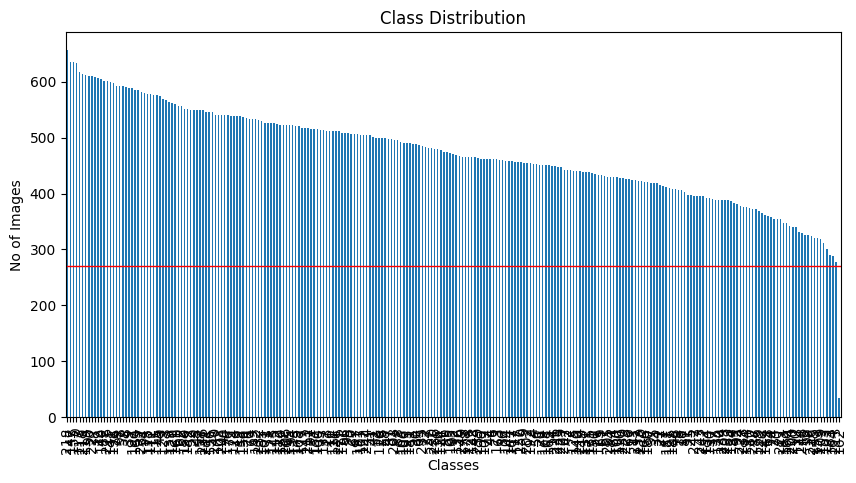

In [ ]:
## Plotting the class distribution
no_of_samples_per_class = 270
plt.figure( figsize = (10, 5) )
train_df['label'].value_counts().plot( kind = 'bar' )
plt.xlabel('Classes')
plt.ylabel('No of Images')
plt.title('Class Distribution')
# Draw a horizontal line at y = 100
plt.axhline( y = no_of_samples_per_class, color = 'r', linestyle = '-', linewidth = 1 )
plt.show()

In [ ]:
### 162 CLASS HAS ONLY 34 DATA ITEMS, WILL DROP THIS

train_df[train_df['label'] == 162].shape

(34, 2)

In [ ]:
### 251 TOTAL CLASSES
len(train_df['label'].unique())

251

In [ ]:
### HERE WE ARE TAKING 270 IMAGES FOR EACH CLASS AND DROPPING THE CLASS WITH < 270 IMAGES

def take_samples_per_class( train_df, no_of_samples ):
    dropped_columns = []
    df = pd.DataFrame()
    for i in range(251):
        if train_df[ train_df['label'] == i ].shape[0] >= no_of_samples:
            df_ = train_df[ train_df['label'] == i ].iloc[:no_of_samples]
            df  = pd.concat( [df, df_], ignore_index = True )
        else:
            # print('Dropped class -- ',i,'--',labels_dict[i])
            dropped_columns.append(i)
    return df, dropped_columns

df, dropped_columns = take_samples_per_class( train_df, no_of_samples_per_class )
print(f'Dropped columns = {dropped_columns}')
print(df.shape)
df.head(3)

Dropped columns = [162]
(67500, 2)


,img_name,label
0,train_059950.jpg,0
1,train_059372.jpg,0
2,train_059348.jpg,0


In [ ]:
# Shuffle DataFrame rows
df = df.sample(frac=1).reset_index(drop=True)
df.head(6)

,img_name,label
0,train_103335.jpg,214
1,train_008963.jpg,9
2,train_115191.jpg,239
3,train_022272.jpg,92
4,train_086497.jpg,154
5,train_009580.jpg,195


In [ ]:
###  TOTAL CLASSES AFTER CLASS BALANCING 250
num_classes = len(df['label'].unique())
num_classes

250

In [ ]:
## WE DROPPED 162 CLASS, NOW WE HAVE TO ADJUST THE LABELS
sorted(df['label'].unique())[160:174]

[160, 161, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174]

In [ ]:
# Function to adjust labels
def adjust_labels(label):
    if label >= 163:
        return label - 1
    else:
        return label

df['labels'] = df['label'].apply(adjust_labels)
sorted(df['labels'].unique())[160:174]

[160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173]

In [ ]:
print(len(df['label'].unique()))
df.head(2)

250


,img_name,label,labels
0,train_103335.jpg,214,213
1,train_008963.jpg,9,9


In [ ]:
## HERE WE ARE TAKING THE VALIDATION DATA DROM TRAIN SET
def train_and_val_split_func( df ):
    train_df, val_df = train_test_split(df, test_size=0.15, stratify=df['labels'], random_state=42)
    print(f'train set  = {train_df.shape} --- {(train_df.shape[0]/df.shape[0])*100}')
    print(f'valid set  = {val_df.shape} --- {(val_df.shape[0]/df.shape[0])*100}')

    return train_df.reset_index().drop('index', axis =1), val_df.reset_index().drop('index', axis =1)

In [ ]:
## Preprocessing test df
test_df_ = pd.read_csv( '/kaggle/input/ifood-2019-fgvc6/val_labels.csv' )
test_df_ = test_df_[ test_df_['label'] != 162 ] ### DROP 162 CLASS

print('Before Processing: ',sorted(test_df_['label'].unique())[160:174])
test_df_['labels'] = test_df_['label'].apply(adjust_labels) ## fix the classes
print('After Processing:  ',sorted(test_df_['labels'].unique())[160:174])

Before Processing:  [160, 161, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174]
After Processing:   [160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173]


In [ ]:
## train and validation df
train_df_, val_df_ = train_and_val_split_func( df )
print(f'test  set  = {test_df_.shape}')

train set  = (57375, 3) --- 85.0
valid set  = (10125, 3) --- 15.0
test  set  = (11945, 3)


#########################################################################################
#########################################################################################

## 1. Rotation Prediction Class

In [ ]:
class RotationPrediction(nn.Module):

    metrics     = ['Loss', 'Acc1']
    metrics_fmt = [':.4e', ':6.2f']

    def __init__( self, n_classes ):
        super().__init__()
        self.model      = NetworkInNetwork()
        self.latent_dim = 192 * 4 * 4
        self.feat_layer = 'conv2'
        self.n_classes  = n_classes # 250

    def construct_classifier(self):
        classifier = nn.Sequential(
          # affine = False means no learnable parameters for scaling and shifting
          nn.BatchNorm1d( self.latent_dim, affine = False ),
          nn.Linear(      self.latent_dim, self.n_classes )
        )
        return classifier

    def forward(self, images): # images -> ( BS-10, CH-3, H-150, W-150 )
        batch_size      = images.shape[0] # 10
#         print(f'This is the batch size in the forward function: {batch_size}')

        images, targets = self._preprocess(images)
#         print(f'Shape of the images:  {images.shape}')  # [80, 3, 256, 256]
#         print(f'Shape of the targets: {targets.shape}') # [80]

        targets    = targets.to( images.get_device() ) ## true labels

        logits, zs = self.model( images, out_feat_keys = ['classifier', self.feat_layer] ) ## features of ['classifier', 'conv2']
        # zs     --> features of conv2 layer      -- torch.Size([512, 192, 8, 8])
        # logits --> features of classifier layer -- torch.Size([512, 4])
#         print(f'zs shape: {zs.shape}')
#         print(f'Logits shape: {logits.shape}')

        loss    = F.cross_entropy( logits, targets )

        pred    = logits.argmax( dim = -1 )
        correct = pred.eq(targets).float().sum() ### total no of correct predictions
        acc     = correct / targets.shape[0] * 100.

        ## starting 128 images are 0 degrees ( actual images )
        zs = zs[ :batch_size ]           ## zs.shape --> torch.Size([128, 192, 8, 8])
        zs = zs.flatten( start_dim = 1 ) ## torch.Size([128, 12288])

        return dict( Loss = loss, Acc1 = acc ), zs[ :batch_size ] ## torch.Size([128, 12288])

    # this function will only returns the features of conv2 layer
    def encode(self, images, flatten=True):
        zs = self.model( images, out_feat_keys = (self.feat_layer,) )
        return zs.flatten( start_dim = 1 )

    def _preprocess(self, images):
        batch_size   = images.shape[0] # 128
        images_90    = torch.flip(images.transpose(2, 3), (2,))
        images_180   = torch.flip(images, (2, 3))
        images_270   = torch.flip(images, (2,)).transpose(2, 3)

        # Concatenates the original and rotated images along the batch dimension (dim=0)
        images_batch = torch.cat( (images, images_90, images_180, images_270), dim=0 )
        targets      = torch.arange(4).long().repeat(batch_size) # 4 x 128 = 512
        # print(f'Shape of the targets inside preprocess method: {targets.shape}')
        targets      = targets.view(batch_size, 4).transpose(0, 1)
        targets      = targets.contiguous().view(-1) ## tensor([0, 0, 1, 1, 2, 2, 3, 3]) --> repeat(2)
        return images_batch, targets


## 2. BasicBlock Class

In [ ]:
class BasicBlock(nn.Module):
    def __init__(self, in_planes, out_planes, kernel_size):
        super(BasicBlock, self).__init__()

        padding     = ( kernel_size - 1 ) // 2
        self.layers = nn.Sequential()

        self.layers.add_module('Conv', nn.Conv2d( in_planes, out_planes, kernel_size=kernel_size, stride=2, padding=1, bias=False ) )
        self.layers.add_module('BatchNorm', nn.BatchNorm2d(out_planes))
        self.layers.add_module('ReLU',      nn.ReLU(inplace=True))

    def forward(self, x):
        return self.layers(x)

## 3. Global Average Pooling Class

In [ ]:
class GlobalAveragePooling(nn.Module):
    def __init__(self):
        super(GlobalAveragePooling, self).__init__()

    def forward(self, feat):
        num_channels = feat.size(1)
        return F.avg_pool2d(feat, (feat.size(2), feat.size(3))).view(-1, num_channels)

## 4. NetworkInNetwork Class

In [ ]:
class NetworkInNetwork(nn.Module):

    def __init__(self):
        super(NetworkInNetwork, self).__init__()

        num_classes      = 4
        num_inchannels   = 3
        num_stages       = 4
        use_avg_on_conv3 = False

        nChannels  = 6
        nChannels2 = 12
        nChannels3 = 24
        nChannels4 = 48
        nChannels5 = 96
        nChannels6 = 192

        blocks = [ nn.Sequential() for i in range(num_stages) ]
        # print(f'blocks: {blocks}')

        # 1st block
        blocks[0].add_module('Block1_ConvB1', BasicBlock(num_inchannels, nChannels, kernel_size=3 ))
        blocks[0].add_module('Block1_ConvB2', BasicBlock(nChannels,  nChannels2, kernel_size=3))
        blocks[0].add_module('Block1_ConvB3', BasicBlock(nChannels2, nChannels3, kernel_size=3))
#       blocks[0].add_module('Block1_MaxPool', nn.MaxPool2d(kernel_size=3,stride=2,padding=1))

        # 2nd block
        blocks[1].add_module('Block2_ConvB1',  BasicBlock(nChannels3, nChannels4, kernel_size=3))
        blocks[1].add_module('Block2_ConvB2',  BasicBlock(nChannels4,  nChannels5, kernel_size=3))
        blocks[1].add_module('Block2_ConvB3',  BasicBlock(nChannels5,  nChannels6, kernel_size=3))
#       blocks[1].add_module('Block2_AvgPool', nn.AvgPool2d(kernel_size=3,stride=2,padding=1))

        # 3rd block
        blocks[2].add_module('Block3_ConvB1',  BasicBlock(nChannels6, nChannels6, 3))
        blocks[2].add_module('Block3_ConvB2',  BasicBlock(nChannels6, nChannels6, 1))
        blocks[2].add_module('Block3_ConvB3',  BasicBlock(nChannels6, nChannels6, 1))

#         if num_stages > 3 and use_avg_on_conv3:
#             blocks[2].add_module('Block3_AvgPool', nn.AvgPool2d(kernel_size=3,stride=2,padding=1))

        for s in range(3, num_stages):
            blocks[s].add_module('Block'+str(s+1)+'_ConvB1',  BasicBlock(nChannels6, nChannels6, 3))
#             blocks[s].add_module('Block'+str(s+1)+'_ConvB2',  BasicBlock(nChannels6, nChannels6, 1))
#             blocks[s].add_module('Block'+str(s+1)+'_ConvB3',  BasicBlock(nChannels6, nChannels6, 1))

        # classifier
        blocks.append( nn.Sequential() )
#         blocks[-1].add_module('GlobalAveragePooling',  GlobalAveragePooling())
        blocks[-1].add_module('Classifier', nn.Linear( nChannels6, num_classes ))

        self._feature_blocks = nn.ModuleList(blocks)
#         print(f'all feature blocks: {self._feature_blocks}')
        self.all_feat_names = [ 'conv'+str(s+1) for s in range(num_stages) ] + ['classifier',]
#         print(f'all_feat_names: --- {self.all_feat_names}')
        assert( len(self.all_feat_names) == len(self._feature_blocks) )

    def forward( self, x, out_feat_keys = None ): # x.shape --> # [40, 3, 150, 150]
#         print(f'x.shape: {x.shape}')
#         print(f'out_feat_keys: {out_feat_keys}') #  ['classifier', 'conv2' ]

        out_feat_keys, max_out_feat = self._parse_out_keys_arg(out_feat_keys)

        out_feats = [None] * len( out_feat_keys ) # 2
        # print(f'Length of out_feats: {len(out_feats)} ')
#         print(f'out_feats: {out_feats}')

        feat = x ## x --> images
#         print(f'Images shape: {feat.shape}') # torch.Size([40, 3, 150, 150])

        for f in range( max_out_feat + 1 ):       # 3 total blocks
#             print(f'Block number: {f}')
            key  = self.all_feat_names[f]           # conv1 for 0th loop
#             print(f'Key : {key}')

            if key == 'classifier':
                feat = feat.view( feat.shape[0], -1 )

            feat = self._feature_blocks[f](feat)   # pass an image to the model block and extract features
#             print(f'feat shape: {feat.shape}\n')

            if key in out_feat_keys: #  ['classifier', 'conv2' ]
#                 print(f'KEY FOUND ........... {key}')
                out_feats[ out_feat_keys.index(key) ] = feat

        out_feats = out_feats[0] if len(out_feats) == 1 else out_feats
#         print(f'Model will return list with length: {len(out_feats)}')
        ## it will return set of 2 features if out_feat_keys = 2
        return out_feats

    def _parse_out_keys_arg( self, out_feat_keys ):
#         print(f'out_feat_keys: {out_feat_keys}')  #  ['classifier', 'conv2' ]

        # By default return the features of the last layer / module.
        out_feat_keys = [ self.all_feat_names[-1], ] if out_feat_keys is None else out_feat_keys

        if len(out_feat_keys) == 0:
            raise ValueError('Empty list of output feature keys.')

        for f, key in enumerate(out_feat_keys): #  ['classifier', 'conv2' ]
            if key not in self.all_feat_names:
                raise ValueError('Feature with name {0} does not exist. Existing features: {1}.'.format(key, self.all_feat_names))
            elif key in out_feat_keys[:f]:
                raise ValueError('Duplicate output feature key: {0}.'.format(key))

        # Find the highest output feature in `out_feat_keys
        max_out_feat = max( [ self.all_feat_names.index(key) for key in out_feat_keys ] )

        return out_feat_keys, max_out_feat

    def weight_initialization(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                if m.weight.requires_grad:
                    n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                    m.weight.data.normal_(0, math.sqrt(2. / n))
            elif isinstance(m, nn.BatchNorm2d):
                if m.weight.requires_grad:
                    m.weight.data.fill_(1)
                if m.bias.requires_grad:
                    m.bias.data.zero_()
            elif isinstance(m, nn.Linear):
                if m.bias.requires_grad:
                    m.bias.data.zero_()

## 5. Utility Function

In [ ]:
def unnormalize(images):
    mu     = [ 0.4914, 0.4822, 0.4465 ]
    stddev = [ 0.2023, 0.1994, 0.2010 ]

    mu     = torch.FloatTensor(mu).view(1, 3, 1, 1)
    stddev = torch.FloatTensor(stddev).view(1, 3, 1, 1)
    return images * stddev + mu

In [ ]:
# Computes the accuracy over the k top predictions for the specified values of k

def accuracy( output, target, topk = (1,) ):
    with torch.no_grad():
        maxk       = max(topk)      ## 5
        batch_size = target.size(0) ## 10
#         print(f'This is the batch size: {batch_size}')

        # print('ACCURACY ....................')
        # print(f'output shape: {output.shape}') ## output shape: torch.Size([10, 250]) -- 250 classes
        # print(f'target shape: {target.shape}') ## target shape: torch.Size([10])

        # returns the top 5 predictions for each sample in the batch.
        _, pred = output.topk( maxk, 1, True, True ) # pred --> ( batch_size, maxk ) -- ## torch.Size([10, 5])
        # print(pred.shape)

        # Transpose the Prediction Tensor
        pred    = pred.t() # ( maxk, batch_size ) -- ## torch.Size([5, 10])
        # print(f'shape of pred after transpose: {pred.shape}')

        correct = pred.eq( target.view(1, -1).expand_as(pred) ) #  target.view( 1, -1 ) -- (1, batch_size) -- torch.Size([1, 128])
        ## target.view(1, -1).expand_as(pred) --> output = torch.Size([5, 10])
        ## correct.shape = torch.Size([5, 12])

        res = []
        for k in topk:
            ## take one row, flatten from this torch.Size([1, 12]) to torch.Size([12]), convert into float, sum the values, keep dimension
            correct_k = correct[:k].reshape(-1).float().sum(0, keepdim=True)
            res.append( correct_k.mul_( 100.0 / batch_size ) )
        return res

## 6. AverageMeter Class

In [ ]:
class AverageMeter(object):
    def __init__(self, name, fmt=':f'):
        self.name = name
        self.fmt  = fmt
        self.reset()

    def reset(self):
        self.val   = 0
        self.avg   = 0
        self.sum   = 0
        self.count = 0

    def update( self, val, n = 1 ):
        self.val    = val
        self.sum   += val * n
        self.count += n
        self.avg    = self.sum / self.count

    def __str__(self):
        fmtstr = '{name} {val' + self.fmt + '} ({avg' + self.fmt + '})'
        return fmtstr.format(**self.__dict__)

## 7. ProgressMeter Class

In [ ]:
class ProgressMeter(object):
    def __init__( self, num_batches, meters, prefix = "" ):
        self.batch_fmtstr = self._get_batch_fmtstr( num_batches ) ## [ {:3d} / 100 ]
        self.meters       = meters
        self.prefix       = prefix

    def display(self, batch):
        entries  = [ self.prefix + self.batch_fmtstr.format(batch) ] ## ['Epoch: [1][  0/100]']
        entries += [ str(meter) for meter in self.meters ]  ## ['Epoch: [1][  0/100]', 'Time  0.500 ( 0.500)', 'Data  0.100 ( 0.100)']
        print('\t'.join(entries)) ## convert list to string

    def _get_batch_fmtstr(self, num_batches):
        num_digits = len( str( num_batches // 1 ) ) ## no of digits in batchsize, if bs = 100 --> 3
        fmt =  '{:' + str( num_digits ) + 'd}'      ##  {:3d}

        return '[' + fmt + '/' + fmt.format(num_batches) + ']' ## [ {:3d} / 100 ]

## 8. Train Function

In [ ]:
def train( train_loader, rot_pred_model, linear_classifier, optimizer, optimizer_linear, epoch ):

    batch_time = AverageMeter('Time', ':6.3f')
    data_time  = AverageMeter('Data', ':6.3f')
    top1       = AverageMeter('LinearAcc@1', ':6.2f')
    top5       = AverageMeter('LinearAcc@5', ':6.2f')

    # print(f'metrics: ----------------- {metrics}')     # ['Loss', 'Acc1']
    # print(f'metrics_format: ---------- {metrics_fmt}') # [':.4e', ':6.2f']

    avg_meters = { k: AverageMeter( k, fmt ) for k, fmt in zip( metrics, metrics_fmt ) }

    progress   = ProgressMeter( len(train_loader), [ batch_time, data_time, top1, top5 ] + list( avg_meters.values() ), prefix = "Epoch: [{}]".format(epoch) )

    # switch to train mode
    rot_pred_model.train()
    linear_classifier.train()

    end = time.time()
    for i, ( images, target ) in enumerate( tqdm(train_loader) ):

        # images.shape --> torch.Size([128, 3, 32, 32])
        # target.shape --> torch.Size([128])

        # measure data loading time
        data_time.update( time.time() - end )

        # compute loss
        # isinstance function will check if images is an instance of either tuple or list
        if isinstance(images, (tuple, list)):

            # Special case for SimCLR which returns a tuple of 2 image batches
            bs     = images[0].shape[0]
            images = [ x.cuda() for x in images ]

        else:
            bs     = images.shape[0]
            images = images.cuda()

        target  = target.cuda()

        # output --> output dict with loss and acc of rotation prediction ,
        # zs --> features of conv2 layer
        output_dict, zs = rot_pred_model(images)
        zs      = zs.detach() ##

        # print(f'Output dict: {output_dict}')
        # print(f'shape of zs:  {zs.shape}' ) # torch.Size([128, 12288])

        for k, v in output_dict.items():
            avg_meters[k].update( v.item(), bs )

        # compute gradient and optimizer step for SSL task ...........................................................
        optimizer.zero_grad()
        output_dict['Loss'].backward()
        optimizer.step()

        # compute gradient and optimizer step for CLASSIFIER .........................................................
        # feed the conv2 layer features to linear CLASSIFIER (which has only batch norm and linear layer)
        logits = linear_classifier(zs)
        loss   = F.cross_entropy( logits, target )

        acc1, acc5 = accuracy( logits, target, topk = ( 1, 5 ) )
        top1.update( acc1[0], bs )
        top5.update( acc5[0], bs )

        optimizer_linear.zero_grad()
        loss.backward()
        optimizer_linear.step()

        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()

#         if i % log_interval == 0:
    progress.display(i)
    data = torch.FloatTensor( [ avg_meters['Loss'].avg, top1.avg, top5.avg ] + [ v.avg for v in avg_meters.values() ] )
    return data

## 9. Validation Function

In [ ]:
def validate( val_loader, model, linear_classifier ):

    batch_time = AverageMeter('Time', ':6.3f')
    data_time  = AverageMeter('Data', ':6.3f')
    top1       = AverageMeter('LinearAcc@1', ':6.2f')
    top5       = AverageMeter('LinearAcc@5', ':6.2f')

    avg_meters = { k: AverageMeter(k, fmt) for k, fmt in zip( metrics, metrics_fmt ) }
    progress   = ProgressMeter( len(val_loader), [ batch_time, data_time, top1, top5 ] + list( avg_meters.values() ), prefix="Valid: " )

    # switch to evaluate mode
    model.eval()
    linear_classifier.eval()

    with torch.no_grad():
        end = time.time()
        for i, (images, target) in enumerate( tqdm(val_loader) ):

            # compute and measure loss
            if isinstance(images, (tuple, list)):
                # Special case for SimCLR which returns a tuple of 2 image batches
                bs     = images[0].shape[0]
                images = [x.cuda() for x in images]

            else:
                bs     = images.shape[0]
                images = images.cuda()

            target   = target.cuda()
            out, zs  = model(images)

            for k, v in out.items():
                avg_meters[k].update(v.item(), bs)

            logits     = linear_classifier(zs)
            acc1, acc5 = accuracy(logits, target, topk=(1, 5))
            top1.update( acc1[0], bs )
            top5.update( acc5[0], bs )

            # measure elapsed time
            batch_time.update( time.time() - end )
            end = time.time()

#             if i % log_interval == 0:
    progress.display(i)

    data = torch.FloatTensor( [ avg_meters['Loss'].avg, top1.avg, top5.avg ] + [ v.avg for v in avg_meters.values() ] )

    print_str = f' * LinearAcc@1 {data[1]:.3f} LinearAcc@5 {data[2]:.3f}'
    for i, (k, v) in enumerate(avg_meters.items()):
        print_str += f' {k} {data[i+3]:.3f}'
    print(print_str)

    return data[0], data[1], data

In [ ]:
def save_checkpoint(state, is_best, filename='checkpoint.pth.tar'):
    filename = osp.join(output_dir, filename)
    torch.save(state, filename)
    if is_best:
        shutil.copyfile(filename, osp.join(output_dir, 'model_best.pth.tar'))


## 10. Data Loader

In [ ]:
def get_transform( train = True ):
    if train:
        transform = transforms.Compose([
                    transforms.RandomCrop(256, padding=4),
                    transforms.RandomHorizontalFlip(),
                    transforms.ToTensor(),
                    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))
        ])
    else:
        transform = transforms.Compose([
                    transforms.Resize( (256, 256) ),
                    transforms.ToTensor(),
                    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))
        ])

    return transform

In [ ]:
class MyDataloader(Dataset):

    def __init__(self, dir_path, labels_df, transform):
        # self.labels_df = pd.read_csv( labels_csv )
        self.labels_df = labels_df
        self.dir_path  = dir_path
        self.transform = transform

    def __len__(self):
        return len(self.labels_df)

    def __getitem__(self, idx):

        cur_index  = self.labels_df.iloc[idx]

        img_path = os.path.join( self.dir_path, cur_index[0])  # image path
        img      = Image.open(img_path).convert('RGB')

        ## apply transform
        transformed     = self.transform( img )

        return transformed.to(torch.float32), cur_index[2]

In [ ]:
train_images_path = '/kaggle/working/extracted_files/train_set'
test_images_path  = '/kaggle/working/extracted_files/val_set'

In [ ]:
## HERE -- TESTING THE DATALOADER CLASS
ds = MyDataloader( train_images_path, train_df_, transform = get_transform( train = True ) )

inp, out = ds.__getitem__( 5 )          # get first item
print(f'input shape -- {inp.shape} --- {inp.dtype}') # print shapes
print(f'output      -- {out}       --- {out.dtype}')

input shape -- torch.Size([3, 256, 256]) --- torch.float32
output      -- 104       --- int64


In [ ]:
train_ds = MyDataloader( train_images_path, train_df_, transform = get_transform( train = True ) )
print( f'trainset length -- {train_ds.__len__()}')

val_ds =  MyDataloader( train_images_path, val_df_, transform = get_transform( train = True ))
print( f'validset length -- {val_ds.__len__()}' )

test_ds = MyDataloader( test_images_path, test_df_, transform = get_transform( train = False ) )
print( f'trainset length -- {test_ds.__len__()}')

trainset length -- 57375
validset length -- 10125
trainset length -- 11945


## 11. Main Block

In [ ]:
batch_size    = 20
epochs        = 1
optimizer     = 'sgd' #'sgd|lars|adam (default: sgd)')
lr            = 0.01
momentum      = 0.9
weight_decay  = 5e-4
warmup_epochs = 0  # number of warmup epochs. If > 0, then the scheduler warmups from lr * batch_size / 256

best_loss = float('inf')
best_acc  = 0.0

log_interval = 1000

output_dir = 'results'
if not osp.exists(output_dir):
    os.makedirs(output_dir)

total_batch_size = batch_size

In [ ]:
## create dataloaders

train_loader =  torch.utils.data.DataLoader(
                train_ds,
                batch_size  = batch_size,
                num_workers = 2,
                pin_memory  = True,
                shuffle     = True,
                drop_last   = True
)

valid_loader =  torch.utils.data.DataLoader(
                val_ds,
                batch_size  = batch_size,
                num_workers = 2,
                pin_memory  = True,
                shuffle     = True,
                drop_last   = True
)

test_loader  =  torch.utils.data.DataLoader(
                test_ds,
                batch_size  = batch_size,
                num_workers = 2,
                pin_memory  = True,
                shuffle     = True,
                drop_last   = True
)

In [ ]:
## NUMBER OF TRAIN AND VALIDATION BATCHES
print(f'Num of batches in train loader   = { int(train_ds.__len__() / batch_size) }') # drop_last = True
print(f'Num of batches in valid loader   = { int(val_ds.__len__()   / batch_size) }') # drop_last = True
# print(f'Num of batches in test  loader   = { int(test_ds.__len__()   / batch_size) }') # drop_last = True

Num of batches in train loader   = 2868
Num of batches in valid loader   = 506


In [ ]:
for i, (images, target) in enumerate(valid_loader):
    print(images.shape)
    print(target.shape)
    break

torch.Size([20, 3, 256, 256])
torch.Size([20])


In [ ]:
## Number of classes
num_classes

250

In [ ]:
model       = RotationPrediction( num_classes )
metrics     = model.metrics     ## ['Loss', 'Acc1']
metrics_fmt = model.metrics_fmt ## [':.4e', ':6.2f']

torch.backends.cudnn.benchmark = True
model.cuda()
print()

In [ ]:
# model

In [ ]:
## total number of parameters in rotation prediction model
print(f"Rotation Prediction Model parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad)} ")

Rotation Prediction Model parameters: 961474 


In [ ]:
# Print the summary of Rotation prediction Model
# summary(model, input_size=(3, 256, 256))

In [ ]:
linear_classifier = model.construct_classifier().cuda()

In [ ]:
# Print the summary of Linear classifier
summary(linear_classifier, (192 * 4 * 4,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
       BatchNorm1d-1                 [-1, 3072]               0
            Linear-2                  [-1, 250]         768,250
Total params: 768,250
Trainable params: 768,250
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.03
Params size (MB): 2.93
Estimated Total Size (MB): 2.97
----------------------------------------------------------------


In [ ]:
optimizer         = torch.optim.SGD( model.parameters(),
                                     lr = lr,
                                     momentum = momentum,
                                     weight_decay = weight_decay,
                                     nesterov = True )

optimizer_linear  = torch.optim.SGD( linear_classifier.parameters(),
                                     lr = lr,
                                     momentum = momentum,
                                     nesterov = True )

In [ ]:
scheduler        = lr_scheduler.CosineAnnealingLR( optimizer,        epochs, 0, -1 )
scheduler_linear = lr_scheduler.CosineAnnealingLR( optimizer_linear, epochs, 0, -1 )

In [ ]:
if warmup_epochs > 0:
    scheduler        = GradualWarmupScheduler( optimizer,
                                               multiplier      = total_batch_size / 256.,
                                               total_epoch     = warmup_epochs,
                                               after_scheduler = scheduler )

    scheduler_linear = GradualWarmupScheduler( optimizer_linear,
                                               multiplier      = total_batch_size / 256.,
                                               total_epoch     = warmup_epochs,
                                               after_scheduler = scheduler_linear )

In [ ]:
train_loss_rot_pred = []
valid_loss_rot_pred = []

train_acc1_rot_pred = []
valid_acc1_rot_pred = []

train_linear_acc1_acc = []
valid_linear_acc1_acc = []

train_linear_acc5_acc = []
valid_linear_acc5_acc = []

for epoch in range( 100 ):

    train_data = train( train_loader, model, linear_classifier, optimizer, optimizer_linear, epoch )

    val_loss, val_acc, val_data = validate( valid_loader, model, linear_classifier )

    scheduler.step()
    scheduler_linear.step()

    is_best   = val_loss < best_loss
    best_loss = min(val_loss, best_loss)
    save_checkpoint({
                    'epoch':             epoch + 1,
                    'state_dict':        model.state_dict(),
                    'optimizer':         optimizer.state_dict(),
                    'scheduler':         scheduler.state_dict(),
                    'state_dict_linear': linear_classifier.state_dict(),
                    'optimizer_linear':  optimizer_linear.state_dict(),
                    'schedular_linear':  scheduler_linear.state_dict(),
                    'best_loss':         best_loss,
                    'best_acc':          val_acc
                    }, is_best)

    ## STORING RESULTS FOR TRAINING DATA .........................
    train_linear_acc1_acc.append( train_data[1] ) ## LinearAcc@1
    train_linear_acc5_acc.append( train_data[2] ) ## LinearAcc@5

    train_loss_rot_pred.append( train_data[3] )  ## rotation prediction loss
    train_acc1_rot_pred.append( train_data[4] )  ## rotation prediction acc1

    ## STORING RESULTS FOR VALIDATION DATA .........................
    valid_linear_acc1_acc.append( val_data[1] ) ## LinearAcc@1
    valid_linear_acc5_acc.append( val_data[2] ) ## LinearAcc@5

    valid_loss_rot_pred.append( val_data[3] )  ## rotation prediction loss
    valid_acc1_rot_pred.append( val_data[4] )  ## rotation prediction acc1

history = { 'train_linear_acc1_acc' : train_linear_acc1_acc,
            'train_linear_acc5_acc' : train_linear_acc5_acc,

            'train_loss_rot_pred'   : train_loss_rot_pred,
            'train_acc1_rot_pred'   : train_acc1_rot_pred,

            'valid_linear_acc1_acc' : valid_linear_acc1_acc,
            'valid_linear_acc5_acc' : valid_linear_acc5_acc,

            'valid_loss_rot_pred'   : valid_loss_rot_pred,
            'valid_acc1_rot_pred'   : valid_acc1_rot_pred}

  0%|          | 0/2868 [00:00<?, ?it/s]

Epoch: [0][2867/2868]	Time  0.041 ( 0.035)	Data  0.030 ( 0.020)	LinearAcc@1   0.00 (  3.69)	LinearAcc@5   5.00 ( 11.65)	Loss 4.2268e-01 (5.6627e-01)	Acc1  82.50 ( 78.16)


  0%|          | 0/506 [00:00<?, ?it/s]

Valid: [505/506]	Time  0.010 ( 0.034)	Data  0.000 ( 0.000)	LinearAcc@1  15.00 (  2.34)	LinearAcc@5  20.00 (  8.37)	Loss 7.1847e-01 (5.5825e-01)	Acc1  72.50 ( 78.73)
 * LinearAcc@1 2.342 LinearAcc@5 8.370 Loss 0.558 Acc1 78.728


  0%|          | 0/2868 [00:00<?, ?it/s]

Epoch: [1][2867/2868]	Time  0.039 ( 0.034)	Data  0.029 ( 0.019)	LinearAcc@1  10.00 (  2.76)	LinearAcc@5  15.00 (  9.49)	Loss 5.0218e-01 (5.6352e-01)	Acc1  78.75 ( 78.06)


  0%|          | 0/506 [00:00<?, ?it/s]

Valid: [505/506]	Time  0.008 ( 0.034)	Data  0.000 ( 0.000)	LinearAcc@1   0.00 (  2.77)	LinearAcc@5   0.00 (  8.75)	Loss 7.4836e-01 (5.6307e-01)	Acc1  76.25 ( 78.09)
 * LinearAcc@1 2.767 LinearAcc@5 8.745 Loss 0.563 Acc1 78.093


  0%|          | 0/2868 [00:00<?, ?it/s]

Epoch: [2][2867/2868]	Time  0.042 ( 0.034)	Data  0.032 ( 0.019)	LinearAcc@1   0.00 (  3.89)	LinearAcc@5  20.00 ( 12.22)	Loss 7.2577e-01 (5.3704e-01)	Acc1  72.50 ( 79.16)


  0%|          | 0/506 [00:00<?, ?it/s]

Valid: [505/506]	Time  0.034 ( 0.033)	Data  0.000 ( 0.000)	LinearAcc@1   0.00 (  2.67)	LinearAcc@5   5.00 (  8.79)	Loss 6.6452e-01 (5.3519e-01)	Acc1  76.25 ( 79.17)
 * LinearAcc@1 2.668 LinearAcc@5 8.794 Loss 0.535 Acc1 79.165


  0%|          | 0/2868 [00:00<?, ?it/s]

Epoch: [3][2867/2868]	Time  0.037 ( 0.034)	Data  0.027 ( 0.019)	LinearAcc@1   0.00 (  3.27)	LinearAcc@5   5.00 ( 10.50)	Loss 4.5699e-01 (5.3839e-01)	Acc1  86.25 ( 79.21)


  0%|          | 0/506 [00:00<?, ?it/s]

Valid: [505/506]	Time  0.050 ( 0.034)	Data  0.000 ( 0.000)	LinearAcc@1   5.00 (  2.65)	LinearAcc@5  20.00 (  8.82)	Loss 5.8230e-01 (5.3053e-01)	Acc1  77.50 ( 79.34)
 * LinearAcc@1 2.648 LinearAcc@5 8.824 Loss 0.531 Acc1 79.335


  0%|          | 0/2868 [00:00<?, ?it/s]

Epoch: [4][2867/2868]	Time  0.031 ( 0.034)	Data  0.021 ( 0.019)	LinearAcc@1   0.00 (  4.25)	LinearAcc@5  15.00 ( 12.94)	Loss 4.4090e-01 (5.0934e-01)	Acc1  87.50 ( 80.30)


  0%|          | 0/506 [00:00<?, ?it/s]

Valid: [505/506]	Time  0.054 ( 0.034)	Data  0.000 ( 0.000)	LinearAcc@1  10.00 (  2.26)	LinearAcc@5  15.00 (  8.72)	Loss 4.7178e-01 (5.1163e-01)	Acc1  85.00 ( 80.33)
 * LinearAcc@1 2.263 LinearAcc@5 8.715 Loss 0.512 Acc1 80.331


  0%|          | 0/2868 [00:00<?, ?it/s]

Epoch: [5][2867/2868]	Time  0.041 ( 0.034)	Data  0.031 ( 0.019)	LinearAcc@1   5.00 (  3.31)	LinearAcc@5  10.00 ( 10.68)	Loss 5.4957e-01 (5.1487e-01)	Acc1  73.75 ( 80.15)


  0%|          | 0/506 [00:00<?, ?it/s]

Valid: [505/506]	Time  0.052 ( 0.033)	Data  0.000 ( 0.000)	LinearAcc@1   0.00 (  2.44)	LinearAcc@5  10.00 (  8.17)	Loss 5.5722e-01 (5.5887e-01)	Acc1  76.25 ( 78.12)
 * LinearAcc@1 2.441 LinearAcc@5 8.172 Loss 0.559 Acc1 78.115


  0%|          | 0/2868 [00:00<?, ?it/s]

Epoch: [6][2867/2868]	Time  0.036 ( 0.034)	Data  0.026 ( 0.019)	LinearAcc@1   0.00 (  4.35)	LinearAcc@5  10.00 ( 12.97)	Loss 4.1018e-01 (4.9425e-01)	Acc1  85.00 ( 80.83)


  0%|          | 0/506 [00:00<?, ?it/s]

Valid: [505/506]	Time  0.006 ( 0.034)	Data  0.000 ( 0.000)	LinearAcc@1  10.00 (  2.90)	LinearAcc@5  15.00 (  9.03)	Loss 4.5371e-01 (4.9798e-01)	Acc1  78.75 ( 80.64)
 * LinearAcc@1 2.895 LinearAcc@5 9.032 Loss 0.498 Acc1 80.642


  0%|          | 0/2868 [00:00<?, ?it/s]

Epoch: [7][2867/2868]	Time  0.041 ( 0.034)	Data  0.031 ( 0.019)	LinearAcc@1  10.00 (  3.49)	LinearAcc@5  15.00 ( 11.09)	Loss 2.9212e-01 (4.9696e-01)	Acc1  90.00 ( 80.83)


  0%|          | 0/506 [00:00<?, ?it/s]

Valid: [505/506]	Time  0.006 ( 0.033)	Data  0.000 ( 0.000)	LinearAcc@1   0.00 (  2.63)	LinearAcc@5  10.00 (  8.70)	Loss 5.0726e-01 (5.1127e-01)	Acc1  82.50 ( 80.29)
 * LinearAcc@1 2.628 LinearAcc@5 8.696 Loss 0.511 Acc1 80.292


  0%|          | 0/2868 [00:00<?, ?it/s]

Epoch: [8][2867/2868]	Time  0.016 ( 0.034)	Data  0.000 ( 0.019)	LinearAcc@1  10.00 (  4.54)	LinearAcc@5  25.00 ( 13.50)	Loss 3.8658e-01 (4.8087e-01)	Acc1  83.75 ( 81.37)


  0%|          | 0/506 [00:00<?, ?it/s]

Valid: [505/506]	Time  0.015 ( 0.034)	Data  0.000 ( 0.000)	LinearAcc@1   0.00 (  2.79)	LinearAcc@5  15.00 (  9.29)	Loss 4.8573e-01 (4.8196e-01)	Acc1  83.75 ( 81.12)
 * LinearAcc@1 2.787 LinearAcc@5 9.289 Loss 0.482 Acc1 81.119


  0%|          | 0/2868 [00:00<?, ?it/s]

Epoch: [9][2867/2868]	Time  0.018 ( 0.034)	Data  0.008 ( 0.019)	LinearAcc@1   5.00 (  3.58)	LinearAcc@5  15.00 ( 11.41)	Loss 4.7906e-01 (4.8568e-01)	Acc1  80.00 ( 81.14)


  0%|          | 0/506 [00:00<?, ?it/s]

Valid: [505/506]	Time  0.021 ( 0.033)	Data  0.000 ( 0.000)	LinearAcc@1   0.00 (  2.63)	LinearAcc@5   5.00 (  8.79)	Loss 7.2737e-01 (4.8502e-01)	Acc1  77.50 ( 81.34)
 * LinearAcc@1 2.628 LinearAcc@5 8.794 Loss 0.485 Acc1 81.344


  0%|          | 0/2868 [00:00<?, ?it/s]

Epoch: [10][2867/2868]	Time  0.020 ( 0.034)	Data  0.010 ( 0.019)	LinearAcc@1   0.00 (  4.59)	LinearAcc@5  15.00 ( 13.99)	Loss 2.8506e-01 (4.6893e-01)	Acc1  93.75 ( 81.86)


  0%|          | 0/506 [00:00<?, ?it/s]

Valid: [505/506]	Time  0.007 ( 0.033)	Data  0.000 ( 0.000)	LinearAcc@1   5.00 (  2.61)	LinearAcc@5  10.00 (  9.26)	Loss 2.8210e-01 (4.7379e-01)	Acc1  92.50 ( 81.74)
 * LinearAcc@1 2.609 LinearAcc@5 9.259 Loss 0.474 Acc1 81.744


  0%|          | 0/2868 [00:00<?, ?it/s]

Epoch: [11][2867/2868]	Time  0.032 ( 0.035)	Data  0.022 ( 0.019)	LinearAcc@1   5.00 (  3.76)	LinearAcc@5  10.00 ( 11.94)	Loss 3.2983e-01 (4.7660e-01)	Acc1  85.00 ( 81.63)


  0%|          | 0/506 [00:00<?, ?it/s]

Valid: [505/506]	Time  0.007 ( 0.034)	Data  0.000 ( 0.000)	LinearAcc@1   0.00 (  2.68)	LinearAcc@5  10.00 (  9.40)	Loss 3.9368e-01 (4.9252e-01)	Acc1  88.75 ( 80.98)
 * LinearAcc@1 2.678 LinearAcc@5 9.397 Loss 0.493 Acc1 80.983


  0%|          | 0/2868 [00:00<?, ?it/s]

Epoch: [12][2867/2868]	Time  0.026 ( 0.034)	Data  0.016 ( 0.019)	LinearAcc@1   0.00 (  5.09)	LinearAcc@5  15.00 ( 14.61)	Loss 2.7043e-01 (4.6808e-01)	Acc1  90.00 ( 82.00)


  0%|          | 0/506 [00:00<?, ?it/s]

Valid: [505/506]	Time  0.054 ( 0.033)	Data  0.000 ( 0.000)	LinearAcc@1   5.00 (  2.95)	LinearAcc@5   5.00 (  9.81)	Loss 4.9112e-01 (4.7220e-01)	Acc1  85.00 ( 81.85)
 * LinearAcc@1 2.955 LinearAcc@5 9.812 Loss 0.472 Acc1 81.848


  0%|          | 0/2868 [00:00<?, ?it/s]

Epoch: [13][2867/2868]	Time  0.016 ( 0.034)	Data  0.000 ( 0.019)	LinearAcc@1   0.00 (  3.80)	LinearAcc@5  10.00 ( 12.15)	Loss 4.3858e-01 (4.6786e-01)	Acc1  80.00 ( 81.94)


  0%|          | 0/506 [00:00<?, ?it/s]

Valid: [505/506]	Time  0.043 ( 0.033)	Data  0.000 ( 0.000)	LinearAcc@1  10.00 (  2.91)	LinearAcc@5  20.00 (  9.42)	Loss 8.9279e-01 (4.7714e-01)	Acc1  71.25 ( 81.60)
 * LinearAcc@1 2.905 LinearAcc@5 9.417 Loss 0.477 Acc1 81.598


  0%|          | 0/2868 [00:00<?, ?it/s]

Epoch: [14][2867/2868]	Time  0.041 ( 0.034)	Data  0.031 ( 0.019)	LinearAcc@1  10.00 (  4.91)	LinearAcc@5  15.00 ( 14.32)	Loss 7.6835e-01 (4.5166e-01)	Acc1  68.75 ( 82.50)


  0%|          | 0/506 [00:00<?, ?it/s]

Valid: [505/506]	Time  0.018 ( 0.034)	Data  0.000 ( 0.000)	LinearAcc@1   0.00 (  2.91)	LinearAcc@5  10.00 (  9.95)	Loss 4.4213e-01 (4.5744e-01)	Acc1  85.00 ( 82.36)
 * LinearAcc@1 2.905 LinearAcc@5 9.951 Loss 0.457 Acc1 82.364


  0%|          | 0/2868 [00:00<?, ?it/s]

Epoch: [15][2867/2868]	Time  0.017 ( 0.034)	Data  0.000 ( 0.019)	LinearAcc@1  10.00 (  4.08)	LinearAcc@5  35.00 ( 12.73)	Loss 4.8001e-01 (4.6445e-01)	Acc1  81.25 ( 82.05)


  0%|          | 0/506 [00:00<?, ?it/s]

Valid: [505/506]	Time  0.007 ( 0.033)	Data  0.000 ( 0.000)	LinearAcc@1   5.00 (  2.85)	LinearAcc@5  15.00 (  9.25)	Loss 9.0053e-01 (6.2190e-01)	Acc1  58.75 ( 76.79)
 * LinearAcc@1 2.846 LinearAcc@5 9.249 Loss 0.622 Acc1 76.793


  0%|          | 0/2868 [00:00<?, ?it/s]

Epoch: [16][2867/2868]	Time  0.016 ( 0.035)	Data  0.001 ( 0.019)	LinearAcc@1   5.00 (  5.37)	LinearAcc@5  20.00 ( 15.25)	Loss 2.3568e-01 (4.5058e-01)	Acc1  88.75 ( 82.57)


  0%|          | 0/506 [00:00<?, ?it/s]

Valid: [505/506]	Time  0.006 ( 0.033)	Data  0.000 ( 0.000)	LinearAcc@1   5.00 (  2.88)	LinearAcc@5  10.00 (  9.94)	Loss 4.3986e-01 (4.6608e-01)	Acc1  83.75 ( 82.05)
 * LinearAcc@1 2.875 LinearAcc@5 9.941 Loss 0.466 Acc1 82.045


  0%|          | 0/2868 [00:00<?, ?it/s]

Epoch: [17][2867/2868]	Time  0.021 ( 0.034)	Data  0.011 ( 0.019)	LinearAcc@1   5.00 (  4.18)	LinearAcc@5  10.00 ( 12.84)	Loss 3.1847e-01 (4.5885e-01)	Acc1  87.50 ( 82.36)


  0%|          | 0/506 [00:00<?, ?it/s]

Valid: [505/506]	Time  0.050 ( 0.033)	Data  0.000 ( 0.000)	LinearAcc@1   0.00 (  2.53)	LinearAcc@5  10.00 (  9.07)	Loss 6.0060e-01 (4.9725e-01)	Acc1  82.50 ( 80.55)
 * LinearAcc@1 2.530 LinearAcc@5 9.071 Loss 0.497 Acc1 80.551


  0%|          | 0/2868 [00:00<?, ?it/s]

Epoch: [18][2867/2868]	Time  0.042 ( 0.034)	Data  0.031 ( 0.019)	LinearAcc@1   0.00 (  5.07)	LinearAcc@5   5.00 ( 15.01)	Loss 4.6091e-01 (4.5470e-01)	Acc1  85.00 ( 82.44)


  0%|          | 0/506 [00:00<?, ?it/s]

Valid: [505/506]	Time  0.006 ( 0.033)	Data  0.000 ( 0.000)	LinearAcc@1   0.00 (  2.76)	LinearAcc@5  10.00 (  9.48)	Loss 3.7988e-01 (4.6549e-01)	Acc1  88.75 ( 82.01)
 * LinearAcc@1 2.757 LinearAcc@5 9.476 Loss 0.465 Acc1 82.008


  0%|          | 0/2868 [00:00<?, ?it/s]

Epoch: [19][2867/2868]	Time  0.046 ( 0.034)	Data  0.034 ( 0.019)	LinearAcc@1   0.00 (  4.15)	LinearAcc@5   0.00 ( 12.94)	Loss 3.2627e-01 (4.5608e-01)	Acc1  88.75 ( 82.35)


  0%|          | 0/506 [00:00<?, ?it/s]

Valid: [505/506]	Time  0.007 ( 0.034)	Data  0.000 ( 0.000)	LinearAcc@1   0.00 (  2.55)	LinearAcc@5   0.00 (  8.87)	Loss 6.5788e-01 (4.9635e-01)	Acc1  73.75 ( 80.98)
 * LinearAcc@1 2.549 LinearAcc@5 8.874 Loss 0.496 Acc1 80.983


  0%|          | 0/2868 [00:00<?, ?it/s]

Epoch: [20][2867/2868]	Time  0.016 ( 0.034)	Data  0.001 ( 0.019)	LinearAcc@1   5.00 (  5.15)	LinearAcc@5  20.00 ( 15.06)	Loss 3.9090e-01 (4.4750e-01)	Acc1  88.75 ( 82.72)


  0%|          | 0/506 [00:00<?, ?it/s]

Valid: [505/506]	Time  0.007 ( 0.033)	Data  0.000 ( 0.000)	LinearAcc@1   5.00 (  2.79)	LinearAcc@5  15.00 (  9.66)	Loss 4.9423e-01 (4.5611e-01)	Acc1  85.00 ( 82.69)
 * LinearAcc@1 2.787 LinearAcc@5 9.664 Loss 0.456 Acc1 82.693


  0%|          | 0/2868 [00:00<?, ?it/s]

Epoch: [21][2867/2868]	Time  0.017 ( 0.034)	Data  0.000 ( 0.019)	LinearAcc@1   0.00 (  4.33)	LinearAcc@5   0.00 ( 13.17)	Loss 1.0742e+00 (4.5085e-01)	Acc1  52.50 ( 82.62)


  0%|          | 0/506 [00:00<?, ?it/s]

Valid: [505/506]	Time  0.050 ( 0.033)	Data  0.000 ( 0.000)	LinearAcc@1   0.00 (  3.03)	LinearAcc@5   0.00 (  9.80)	Loss 3.3397e-01 (5.2924e-01)	Acc1  87.50 ( 79.38)
 * LinearAcc@1 3.034 LinearAcc@5 9.802 Loss 0.529 Acc1 79.375


  0%|          | 0/2868 [00:00<?, ?it/s]

Epoch: [22][2867/2868]	Time  0.017 ( 0.034)	Data  0.007 ( 0.019)	LinearAcc@1  10.00 (  5.31)	LinearAcc@5  30.00 ( 15.59)	Loss 1.4860e-01 (4.4625e-01)	Acc1  97.50 ( 82.83)


  0%|          | 0/506 [00:00<?, ?it/s]

Valid: [505/506]	Time  0.045 ( 0.034)	Data  0.000 ( 0.000)	LinearAcc@1   0.00 (  2.94)	LinearAcc@5   5.00 ( 10.33)	Loss 4.5213e-01 (4.6009e-01)	Acc1  82.50 ( 82.09)
 * LinearAcc@1 2.945 LinearAcc@5 10.326 Loss 0.460 Acc1 82.095


  0%|          | 0/2868 [00:00<?, ?it/s]

Epoch: [23][2867/2868]	Time  0.017 ( 0.034)	Data  0.001 ( 0.019)	LinearAcc@1  10.00 (  4.29)	LinearAcc@5  15.00 ( 13.10)	Loss 4.0271e-01 (4.4854e-01)	Acc1  86.25 ( 82.69)


  0%|          | 0/506 [00:00<?, ?it/s]

Valid: [505/506]	Time  0.006 ( 0.033)	Data  0.000 ( 0.000)	LinearAcc@1   0.00 (  2.73)	LinearAcc@5   0.00 (  9.67)	Loss 6.7551e-01 (4.5778e-01)	Acc1  70.00 ( 82.30)
 * LinearAcc@1 2.727 LinearAcc@5 9.674 Loss 0.458 Acc1 82.300


  0%|          | 0/2868 [00:00<?, ?it/s]

Epoch: [24][2867/2868]	Time  0.042 ( 0.034)	Data  0.032 ( 0.019)	LinearAcc@1   0.00 (  5.52)	LinearAcc@5   5.00 ( 16.04)	Loss 5.5438e-01 (4.3719e-01)	Acc1  80.00 ( 83.08)


  0%|          | 0/506 [00:00<?, ?it/s]

Valid: [505/506]	Time  0.030 ( 0.033)	Data  0.000 ( 0.000)	LinearAcc@1   0.00 (  3.10)	LinearAcc@5   0.00 ( 10.25)	Loss 5.3629e-01 (4.4975e-01)	Acc1  77.50 ( 82.52)
 * LinearAcc@1 3.103 LinearAcc@5 10.247 Loss 0.450 Acc1 82.520


  0%|          | 0/2868 [00:00<?, ?it/s]

Epoch: [25][2867/2868]	Time  0.040 ( 0.034)	Data  0.030 ( 0.019)	LinearAcc@1   5.00 (  4.24)	LinearAcc@5   5.00 ( 13.30)	Loss 4.5833e-01 (4.4354e-01)	Acc1  80.00 ( 82.95)


  0%|          | 0/506 [00:00<?, ?it/s]

Valid: [505/506]	Time  0.006 ( 0.033)	Data  0.000 ( 0.000)	LinearAcc@1  10.00 (  3.10)	LinearAcc@5  10.00 (  9.96)	Loss 4.7557e-01 (5.0151e-01)	Acc1  81.25 ( 80.82)
 * LinearAcc@1 3.103 LinearAcc@5 9.960 Loss 0.502 Acc1 80.823


  0%|          | 0/2868 [00:00<?, ?it/s]

Epoch: [26][2867/2868]	Time  0.037 ( 0.034)	Data  0.027 ( 0.019)	LinearAcc@1  15.00 (  5.69)	LinearAcc@5  20.00 ( 16.18)	Loss 4.2680e-01 (4.3613e-01)	Acc1  81.25 ( 83.17)


  0%|          | 0/506 [00:00<?, ?it/s]

Valid: [505/506]	Time  0.007 ( 0.033)	Data  0.000 ( 0.000)	LinearAcc@1   5.00 (  3.21)	LinearAcc@5  15.00 ( 10.60)	Loss 2.5704e-01 (4.4711e-01)	Acc1  92.50 ( 82.93)
 * LinearAcc@1 3.211 LinearAcc@5 10.603 Loss 0.447 Acc1 82.927


  0%|          | 0/2868 [00:00<?, ?it/s]

Epoch: [27][2867/2868]	Time  0.050 ( 0.035)	Data  0.040 ( 0.019)	LinearAcc@1   5.00 (  4.42)	LinearAcc@5  15.00 ( 13.39)	Loss 2.6019e-01 (4.4386e-01)	Acc1  88.75 ( 82.92)


  0%|          | 0/506 [00:00<?, ?it/s]

Valid: [505/506]	Time  0.050 ( 0.033)	Data  0.000 ( 0.000)	LinearAcc@1   0.00 (  3.45)	LinearAcc@5   0.00 ( 10.39)	Loss 2.0985e-01 (4.5174e-01)	Acc1  96.25 ( 82.62)
 * LinearAcc@1 3.449 LinearAcc@5 10.385 Loss 0.452 Acc1 82.616


  0%|          | 0/2868 [00:00<?, ?it/s]

Epoch: [28][2867/2868]	Time  0.038 ( 0.034)	Data  0.027 ( 0.018)	LinearAcc@1  10.00 (  5.85)	LinearAcc@5  30.00 ( 16.38)	Loss 3.3711e-01 (4.2688e-01)	Acc1  86.25 ( 83.59)


  0%|          | 0/506 [00:00<?, ?it/s]

Valid: [505/506]	Time  0.008 ( 0.034)	Data  0.000 ( 0.000)	LinearAcc@1  15.00 (  3.37)	LinearAcc@5  25.00 ( 10.83)	Loss 1.5870e-01 (4.4081e-01)	Acc1  95.00 ( 82.96)
 * LinearAcc@1 3.370 LinearAcc@5 10.830 Loss 0.441 Acc1 82.959


  0%|          | 0/2868 [00:00<?, ?it/s]

Epoch: [29][2867/2868]	Time  0.039 ( 0.034)	Data  0.029 ( 0.019)	LinearAcc@1   5.00 (  4.50)	LinearAcc@5  10.00 ( 13.66)	Loss 3.4884e-01 (4.4046e-01)	Acc1  85.00 ( 83.09)


  0%|          | 0/506 [00:00<?, ?it/s]

Valid: [505/506]	Time  0.041 ( 0.033)	Data  0.000 ( 0.000)	LinearAcc@1  10.00 (  3.18)	LinearAcc@5  20.00 ( 10.51)	Loss 5.2930e-01 (4.7917e-01)	Acc1  75.00 ( 81.57)
 * LinearAcc@1 3.182 LinearAcc@5 10.514 Loss 0.479 Acc1 81.571


  0%|          | 0/2868 [00:00<?, ?it/s]

Epoch: [30][2867/2868]	Time  0.016 ( 0.035)	Data  0.000 ( 0.019)	LinearAcc@1  10.00 (  5.64)	LinearAcc@5  15.00 ( 16.16)	Loss 6.0376e-01 (4.3943e-01)	Acc1  77.50 ( 83.10)


  0%|          | 0/506 [00:00<?, ?it/s]

Valid: [505/506]	Time  0.038 ( 0.034)	Data  0.000 ( 0.000)	LinearAcc@1   0.00 (  3.08)	LinearAcc@5  10.00 ( 10.62)	Loss 6.8899e-01 (4.4802e-01)	Acc1  71.25 ( 82.81)
 * LinearAcc@1 3.083 LinearAcc@5 10.623 Loss 0.448 Acc1 82.811


  0%|          | 0/2868 [00:00<?, ?it/s]

Epoch: [31][2867/2868]	Time  0.016 ( 0.034)	Data  0.001 ( 0.019)	LinearAcc@1   5.00 (  4.46)	LinearAcc@5  10.00 ( 13.72)	Loss 3.3844e-01 (4.3953e-01)	Acc1  87.50 ( 83.06)


  0%|          | 0/506 [00:00<?, ?it/s]

Valid: [505/506]	Time  0.059 ( 0.033)	Data  0.000 ( 0.000)	LinearAcc@1   5.00 (  3.03)	LinearAcc@5  10.00 ( 10.21)	Loss 3.4983e-01 (4.6206e-01)	Acc1  85.00 ( 82.10)
 * LinearAcc@1 3.034 LinearAcc@5 10.208 Loss 0.462 Acc1 82.100


  0%|          | 0/2868 [00:00<?, ?it/s]

Epoch: [32][2867/2868]	Time  0.039 ( 0.034)	Data  0.028 ( 0.019)	LinearAcc@1   5.00 (  5.87)	LinearAcc@5  15.00 ( 16.56)	Loss 4.7955e-01 (4.2526e-01)	Acc1  77.50 ( 83.56)


  0%|          | 0/506 [00:00<?, ?it/s]

Valid: [505/506]	Time  0.006 ( 0.033)	Data  0.000 ( 0.000)	LinearAcc@1   5.00 (  3.10)	LinearAcc@5  15.00 ( 10.28)	Loss 3.7252e-01 (4.3771e-01)	Acc1  83.75 ( 83.23)
 * LinearAcc@1 3.103 LinearAcc@5 10.277 Loss 0.438 Acc1 83.229


  0%|          | 0/2868 [00:00<?, ?it/s]

Epoch: [33][2867/2868]	Time  0.039 ( 0.034)	Data  0.028 ( 0.019)	LinearAcc@1   5.00 (  4.56)	LinearAcc@5   5.00 ( 13.84)	Loss 5.4544e-01 (4.3641e-01)	Acc1  78.75 ( 83.21)


  0%|          | 0/506 [00:00<?, ?it/s]

Valid: [505/506]	Time  0.019 ( 0.034)	Data  0.000 ( 0.000)	LinearAcc@1   0.00 (  3.15)	LinearAcc@5   5.00 ( 10.24)	Loss 9.0631e-01 (4.5619e-01)	Acc1  68.75 ( 82.58)
 * LinearAcc@1 3.152 LinearAcc@5 10.237 Loss 0.456 Acc1 82.582


  0%|          | 0/2868 [00:00<?, ?it/s]

Epoch: [34][2867/2868]	Time  0.014 ( 0.034)	Data  0.002 ( 0.019)	LinearAcc@1  15.00 (  6.03)	LinearAcc@5  35.00 ( 16.97)	Loss 3.8549e-01 (4.2292e-01)	Acc1  88.75 ( 83.77)


  0%|          | 0/506 [00:00<?, ?it/s]

Valid: [505/506]	Time  0.006 ( 0.033)	Data  0.000 ( 0.000)	LinearAcc@1   0.00 (  3.35)	LinearAcc@5   0.00 ( 10.79)	Loss 2.3668e-01 (4.4010e-01)	Acc1  93.75 ( 83.19)
 * LinearAcc@1 3.350 LinearAcc@5 10.791 Loss 0.440 Acc1 83.187


  0%|          | 0/2868 [00:00<?, ?it/s]

Epoch: [35][2867/2868]	Time  0.043 ( 0.034)	Data  0.034 ( 0.019)	LinearAcc@1   5.00 (  4.61)	LinearAcc@5   5.00 ( 13.87)	Loss 5.2407e-01 (4.3689e-01)	Acc1  80.00 ( 83.07)


  0%|          | 0/506 [00:00<?, ?it/s]

Valid: [505/506]	Time  0.028 ( 0.034)	Data  0.000 ( 0.000)	LinearAcc@1   5.00 (  3.23)	LinearAcc@5  10.00 ( 10.42)	Loss 5.8836e-01 (4.4680e-01)	Acc1  75.00 ( 82.87)
 * LinearAcc@1 3.231 LinearAcc@5 10.415 Loss 0.447 Acc1 82.871


  0%|          | 0/2868 [00:00<?, ?it/s]

Epoch: [36][2867/2868]	Time  0.038 ( 0.034)	Data  0.028 ( 0.019)	LinearAcc@1   0.00 (  5.99)	LinearAcc@5   5.00 ( 16.95)	Loss 6.4263e-01 (4.2489e-01)	Acc1  71.25 ( 83.63)


  0%|          | 0/506 [00:00<?, ?it/s]

Valid: [505/506]	Time  0.050 ( 0.035)	Data  0.000 ( 0.000)	LinearAcc@1   0.00 (  3.65)	LinearAcc@5  10.00 ( 11.30)	Loss 4.8958e-01 (4.4048e-01)	Acc1  81.25 ( 83.15)
 * LinearAcc@1 3.646 LinearAcc@5 11.304 Loss 0.440 Acc1 83.147


  0%|          | 0/2868 [00:00<?, ?it/s]

Epoch: [37][2867/2868]	Time  0.043 ( 0.034)	Data  0.033 ( 0.019)	LinearAcc@1   5.00 (  4.48)	LinearAcc@5  15.00 ( 13.92)	Loss 6.9888e-01 (4.3516e-01)	Acc1  72.50 ( 83.17)


  0%|          | 0/506 [00:00<?, ?it/s]

Valid: [505/506]	Time  0.007 ( 0.033)	Data  0.000 ( 0.000)	LinearAcc@1   5.00 (  3.14)	LinearAcc@5  10.00 ( 10.35)	Loss 4.2875e-01 (4.4834e-01)	Acc1  81.25 ( 82.42)
 * LinearAcc@1 3.142 LinearAcc@5 10.346 Loss 0.448 Acc1 82.418


  0%|          | 0/2868 [00:00<?, ?it/s]

Epoch: [38][2867/2868]	Time  0.043 ( 0.034)	Data  0.033 ( 0.018)	LinearAcc@1   5.00 (  6.05)	LinearAcc@5  10.00 ( 17.03)	Loss 3.4358e-01 (4.2043e-01)	Acc1  86.25 ( 83.75)


  0%|          | 0/506 [00:00<?, ?it/s]

Valid: [505/506]	Time  0.047 ( 0.033)	Data  0.000 ( 0.000)	LinearAcc@1   0.00 (  3.38)	LinearAcc@5   0.00 ( 11.16)	Loss 1.9775e-01 (4.3633e-01)	Acc1  92.50 ( 83.09)
 * LinearAcc@1 3.379 LinearAcc@5 11.156 Loss 0.436 Acc1 83.093


  0%|          | 0/2868 [00:00<?, ?it/s]

Epoch: [39][2867/2868]	Time  0.038 ( 0.035)	Data  0.027 ( 0.019)	LinearAcc@1   0.00 (  4.69)	LinearAcc@5  20.00 ( 14.10)	Loss 6.4482e-01 (4.3232e-01)	Acc1  77.50 ( 83.37)


  0%|          | 0/506 [00:00<?, ?it/s]

Valid: [505/506]	Time  0.047 ( 0.034)	Data  0.000 ( 0.000)	LinearAcc@1   5.00 (  3.08)	LinearAcc@5  15.00 (  9.69)	Loss 4.7811e-01 (5.1705e-01)	Acc1  83.75 ( 79.61)
 * LinearAcc@1 3.083 LinearAcc@5 9.694 Loss 0.517 Acc1 79.615


  0%|          | 0/2868 [00:00<?, ?it/s]

Epoch: [40][2867/2868]	Time  0.030 ( 0.034)	Data  0.020 ( 0.019)	LinearAcc@1   5.00 (  5.66)	LinearAcc@5  25.00 ( 16.53)	Loss 7.3681e-01 (4.2376e-01)	Acc1  73.75 ( 83.76)


  0%|          | 0/506 [00:00<?, ?it/s]

Valid: [505/506]	Time  0.050 ( 0.033)	Data  0.000 ( 0.000)	LinearAcc@1  10.00 (  3.54)	LinearAcc@5  15.00 ( 11.03)	Loss 9.5105e-01 (4.3682e-01)	Acc1  57.50 ( 83.03)
 * LinearAcc@1 3.538 LinearAcc@5 11.028 Loss 0.437 Acc1 83.031


  0%|          | 0/2868 [00:00<?, ?it/s]

Epoch: [41][2867/2868]	Time  0.016 ( 0.034)	Data  0.001 ( 0.019)	LinearAcc@1  10.00 (  4.88)	LinearAcc@5  15.00 ( 14.21)	Loss 2.3894e-01 (4.3019e-01)	Acc1  90.00 ( 83.43)


  0%|          | 0/506 [00:00<?, ?it/s]

Valid: [505/506]	Time  0.008 ( 0.034)	Data  0.000 ( 0.000)	LinearAcc@1  10.00 (  2.94)	LinearAcc@5  20.00 (  9.85)	Loss 5.9770e-01 (5.2176e-01)	Acc1  77.50 ( 79.90)
 * LinearAcc@1 2.945 LinearAcc@5 9.852 Loss 0.522 Acc1 79.899


  0%|          | 0/2868 [00:00<?, ?it/s]

Epoch: [42][2867/2868]	Time  0.040 ( 0.034)	Data  0.030 ( 0.019)	LinearAcc@1  10.00 (  5.96)	LinearAcc@5  25.00 ( 16.93)	Loss 2.8493e-01 (4.2730e-01)	Acc1  91.25 ( 83.60)


  0%|          | 0/506 [00:00<?, ?it/s]

Valid: [505/506]	Time  0.050 ( 0.033)	Data  0.000 ( 0.000)	LinearAcc@1  10.00 (  3.04)	LinearAcc@5  10.00 ( 10.52)	Loss 2.2350e-01 (4.3951e-01)	Acc1  91.25 ( 83.33)
 * LinearAcc@1 3.043 LinearAcc@5 10.524 Loss 0.440 Acc1 83.333


  0%|          | 0/2868 [00:00<?, ?it/s]

Epoch: [43][2867/2868]	Time  0.038 ( 0.034)	Data  0.028 ( 0.019)	LinearAcc@1  10.00 (  4.80)	LinearAcc@5  20.00 ( 14.27)	Loss 2.0025e-01 (4.2980e-01)	Acc1  93.75 ( 83.43)


  0%|          | 0/506 [00:00<?, ?it/s]

Valid: [505/506]	Time  0.052 ( 0.034)	Data  0.000 ( 0.000)	LinearAcc@1  15.00 (  2.85)	LinearAcc@5  25.00 ( 10.26)	Loss 6.7910e-01 (4.8072e-01)	Acc1  72.50 ( 81.31)
 * LinearAcc@1 2.846 LinearAcc@5 10.257 Loss 0.481 Acc1 81.309


  0%|          | 0/2868 [00:00<?, ?it/s]

Epoch: [44][2867/2868]	Time  0.041 ( 0.034)	Data  0.031 ( 0.019)	LinearAcc@1  10.00 (  5.84)	LinearAcc@5  25.00 ( 16.54)	Loss 2.5845e-01 (4.2380e-01)	Acc1  86.25 ( 83.67)


  0%|          | 0/506 [00:00<?, ?it/s]

Valid: [505/506]	Time  0.006 ( 0.034)	Data  0.000 ( 0.000)	LinearAcc@1   0.00 (  3.31)	LinearAcc@5  10.00 ( 10.55)	Loss 4.4209e-01 (4.3753e-01)	Acc1  91.25 ( 82.97)
 * LinearAcc@1 3.310 LinearAcc@5 10.553 Loss 0.438 Acc1 82.974


  0%|          | 0/2868 [00:00<?, ?it/s]

Epoch: [45][2867/2868]	Time  0.021 ( 0.034)	Data  0.011 ( 0.019)	LinearAcc@1   5.00 (  4.94)	LinearAcc@5  15.00 ( 14.35)	Loss 2.5775e-01 (4.2540e-01)	Acc1  93.75 ( 83.66)


  0%|          | 0/506 [00:00<?, ?it/s]

Valid: [505/506]	Time  0.007 ( 0.033)	Data  0.000 ( 0.000)	LinearAcc@1   0.00 (  3.38)	LinearAcc@5  10.00 ( 10.19)	Loss 5.2461e-01 (4.6494e-01)	Acc1  78.75 ( 81.86)
 * LinearAcc@1 3.379 LinearAcc@5 10.188 Loss 0.465 Acc1 81.863


  0%|          | 0/2868 [00:00<?, ?it/s]

Epoch: [46][2867/2868]	Time  0.016 ( 0.034)	Data  0.000 ( 0.019)	LinearAcc@1   5.00 (  6.24)	LinearAcc@5  35.00 ( 17.18)	Loss 6.0653e-01 (4.2130e-01)	Acc1  72.50 ( 83.75)


  0%|          | 0/506 [00:00<?, ?it/s]

Valid: [505/506]	Time  0.010 ( 0.034)	Data  0.000 ( 0.000)	LinearAcc@1   0.00 (  3.77)	LinearAcc@5  10.00 ( 11.25)	Loss 1.2297e-01 (4.3798e-01)	Acc1  96.25 ( 83.00)
 * LinearAcc@1 3.775 LinearAcc@5 11.245 Loss 0.438 Acc1 83.001


  0%|          | 0/2868 [00:00<?, ?it/s]

Epoch: [47][2867/2868]	Time  0.014 ( 0.034)	Data  0.004 ( 0.019)	LinearAcc@1   0.00 (  4.83)	LinearAcc@5   5.00 ( 14.55)	Loss 3.1991e-01 (4.2678e-01)	Acc1  86.25 ( 83.61)


  0%|          | 0/506 [00:00<?, ?it/s]

Valid: [505/506]	Time  0.028 ( 0.033)	Data  0.000 ( 0.000)	LinearAcc@1   5.00 (  3.31)	LinearAcc@5  10.00 ( 10.77)	Loss 2.4584e-01 (4.4066e-01)	Acc1  88.75 ( 82.77)
 * LinearAcc@1 3.310 LinearAcc@5 10.771 Loss 0.441 Acc1 82.772


  0%|          | 0/2868 [00:00<?, ?it/s]

Epoch: [48][2867/2868]	Time  0.042 ( 0.034)	Data  0.032 ( 0.019)	LinearAcc@1   0.00 (  6.29)	LinearAcc@5  15.00 ( 17.40)	Loss 4.2712e-01 (4.1601e-01)	Acc1  81.25 ( 83.99)


  0%|          | 0/506 [00:00<?, ?it/s]

Valid: [505/506]	Time  0.051 ( 0.033)	Data  0.000 ( 0.000)	LinearAcc@1   5.00 (  3.29)	LinearAcc@5  10.00 ( 10.55)	Loss 6.3887e-01 (4.2946e-01)	Acc1  73.75 ( 83.31)
 * LinearAcc@1 3.291 LinearAcc@5 10.553 Loss 0.429 Acc1 83.308


  0%|          | 0/2868 [00:00<?, ?it/s]

Epoch: [49][2867/2868]	Time  0.045 ( 0.035)	Data  0.034 ( 0.019)	LinearAcc@1   0.00 (  4.88)	LinearAcc@5  20.00 ( 14.18)	Loss 1.8961e-01 (4.2559e-01)	Acc1  95.00 ( 83.61)


  0%|          | 0/506 [00:00<?, ?it/s]

Valid: [505/506]	Time  0.050 ( 0.034)	Data  0.000 ( 0.000)	LinearAcc@1   0.00 (  3.81)	LinearAcc@5   5.00 ( 11.12)	Loss 3.8048e-01 (4.7271e-01)	Acc1  86.25 ( 81.77)
 * LinearAcc@1 3.814 LinearAcc@5 11.117 Loss 0.473 Acc1 81.769


  0%|          | 0/2868 [00:00<?, ?it/s]

Epoch: [50][2867/2868]	Time  0.039 ( 0.034)	Data  0.029 ( 0.019)	LinearAcc@1  15.00 (  6.40)	LinearAcc@5  25.00 ( 17.51)	Loss 3.3638e-01 (4.1161e-01)	Acc1  88.75 ( 84.25)


  0%|          | 0/506 [00:00<?, ?it/s]

Valid: [505/506]	Time  0.007 ( 0.033)	Data  0.000 ( 0.000)	LinearAcc@1   5.00 (  3.87)	LinearAcc@5  15.00 ( 11.28)	Loss 4.0207e-01 (4.2752e-01)	Acc1  80.00 ( 83.54)
 * LinearAcc@1 3.874 LinearAcc@5 11.285 Loss 0.428 Acc1 83.540


  0%|          | 0/2868 [00:00<?, ?it/s]

Epoch: [51][2867/2868]	Time  0.039 ( 0.035)	Data  0.029 ( 0.019)	LinearAcc@1   5.00 (  4.90)	LinearAcc@5   5.00 ( 14.67)	Loss 3.2220e-01 (4.2323e-01)	Acc1  86.25 ( 83.64)


  0%|          | 0/506 [00:00<?, ?it/s]

Valid: [505/506]	Time  0.037 ( 0.033)	Data  0.000 ( 0.000)	LinearAcc@1   5.00 (  2.75)	LinearAcc@5  15.00 (  9.29)	Loss 5.1738e-01 (5.0223e-01)	Acc1  83.75 ( 80.61)
 * LinearAcc@1 2.747 LinearAcc@5 9.289 Loss 0.502 Acc1 80.605


  0%|          | 0/2868 [00:00<?, ?it/s]

Epoch: [52][2867/2868]	Time  0.027 ( 0.034)	Data  0.017 ( 0.019)	LinearAcc@1   5.00 (  5.61)	LinearAcc@5  20.00 ( 16.42)	Loss 5.2455e-01 (4.3080e-01)	Acc1  76.25 ( 83.33)


  0%|          | 0/506 [00:00<?, ?it/s]

Valid: [505/506]	Time  0.006 ( 0.033)	Data  0.000 ( 0.000)	LinearAcc@1  15.00 (  3.30)	LinearAcc@5  15.00 ( 10.63)	Loss 1.8902e-01 (4.4501e-01)	Acc1  96.25 ( 82.71)
 * LinearAcc@1 3.300 LinearAcc@5 10.632 Loss 0.445 Acc1 82.715


  0%|          | 0/2868 [00:00<?, ?it/s]

Epoch: [53][2867/2868]	Time  0.027 ( 0.035)	Data  0.017 ( 0.019)	LinearAcc@1   0.00 (  4.78)	LinearAcc@5   5.00 ( 14.37)	Loss 5.1590e-01 (4.2422e-01)	Acc1  77.50 ( 83.67)


  0%|          | 0/506 [00:00<?, ?it/s]

Valid: [505/506]	Time  0.030 ( 0.033)	Data  0.000 ( 0.000)	LinearAcc@1   0.00 (  3.41)	LinearAcc@5   5.00 ( 10.74)	Loss 3.8129e-01 (4.4992e-01)	Acc1  88.75 ( 82.52)
 * LinearAcc@1 3.409 LinearAcc@5 10.741 Loss 0.450 Acc1 82.522


  0%|          | 0/2868 [00:00<?, ?it/s]

Epoch: [54][2867/2868]	Time  0.017 ( 0.034)	Data  0.000 ( 0.019)	LinearAcc@1   5.00 (  6.39)	LinearAcc@5  15.00 ( 17.38)	Loss 6.8778e-01 (4.0343e-01)	Acc1  81.25 ( 84.49)


  0%|          | 0/506 [00:00<?, ?it/s]

Valid: [505/506]	Time  0.047 ( 0.034)	Data  0.000 ( 0.000)	LinearAcc@1   0.00 (  3.75)	LinearAcc@5   5.00 ( 11.17)	Loss 4.2047e-01 (4.1870e-01)	Acc1  80.00 ( 83.68)
 * LinearAcc@1 3.745 LinearAcc@5 11.166 Loss 0.419 Acc1 83.678


  0%|          | 0/2868 [00:00<?, ?it/s]

Epoch: [55][2867/2868]	Time  0.028 ( 0.035)	Data  0.018 ( 0.019)	LinearAcc@1   5.00 (  4.83)	LinearAcc@5  15.00 ( 14.63)	Loss 4.5047e-01 (4.2313e-01)	Acc1  81.25 ( 83.68)


  0%|          | 0/506 [00:00<?, ?it/s]

Valid: [505/506]	Time  0.007 ( 0.034)	Data  0.000 ( 0.000)	LinearAcc@1  15.00 (  3.96)	LinearAcc@5  35.00 ( 11.50)	Loss 3.9029e-01 (4.7862e-01)	Acc1  86.25 ( 81.89)
 * LinearAcc@1 3.962 LinearAcc@5 11.502 Loss 0.479 Acc1 81.895


  0%|          | 0/2868 [00:00<?, ?it/s]

Epoch: [56][2867/2868]	Time  0.016 ( 0.035)	Data  0.001 ( 0.019)	LinearAcc@1  10.00 (  6.19)	LinearAcc@5  15.00 ( 17.06)	Loss 5.3195e-01 (4.1830e-01)	Acc1  82.50 ( 83.88)


  0%|          | 0/506 [00:00<?, ?it/s]

Valid: [505/506]	Time  0.006 ( 0.034)	Data  0.000 ( 0.000)	LinearAcc@1   0.00 (  3.55)	LinearAcc@5   5.00 ( 11.02)	Loss 3.5047e-01 (4.3124e-01)	Acc1  88.75 ( 83.38)
 * LinearAcc@1 3.547 LinearAcc@5 11.018 Loss 0.431 Acc1 83.384


  0%|          | 0/2868 [00:00<?, ?it/s]

Epoch: [57][2867/2868]	Time  0.038 ( 0.035)	Data  0.027 ( 0.019)	LinearAcc@1   0.00 (  4.89)	LinearAcc@5   0.00 ( 14.70)	Loss 6.9687e-01 (4.2133e-01)	Acc1  76.25 ( 83.73)


  0%|          | 0/506 [00:00<?, ?it/s]

Valid: [505/506]	Time  0.051 ( 0.034)	Data  0.000 ( 0.000)	LinearAcc@1   5.00 (  3.25)	LinearAcc@5   5.00 ( 10.29)	Loss 3.5016e-01 (4.6105e-01)	Acc1  90.00 ( 82.19)
 * LinearAcc@1 3.251 LinearAcc@5 10.287 Loss 0.461 Acc1 82.186


  0%|          | 0/2868 [00:00<?, ?it/s]

Epoch: [58][2867/2868]	Time  0.016 ( 0.035)	Data  0.000 ( 0.019)	LinearAcc@1   0.00 (  6.28)	LinearAcc@5  20.00 ( 17.42)	Loss 5.2921e-01 (4.0880e-01)	Acc1  81.25 ( 84.34)


  0%|          | 0/506 [00:00<?, ?it/s]

Valid: [505/506]	Time  0.053 ( 0.034)	Data  0.000 ( 0.000)	LinearAcc@1   5.00 (  3.56)	LinearAcc@5   5.00 ( 11.08)	Loss 6.3477e-01 (4.2124e-01)	Acc1  78.75 ( 83.70)
 * LinearAcc@1 3.557 LinearAcc@5 11.077 Loss 0.421 Acc1 83.698


  0%|          | 0/2868 [00:00<?, ?it/s]

Epoch: [59][2867/2868]	Time  0.026 ( 0.035)	Data  0.016 ( 0.019)	LinearAcc@1   5.00 (  4.92)	LinearAcc@5  10.00 ( 14.56)	Loss 3.6068e-01 (4.2001e-01)	Acc1  85.00 ( 83.69)


  0%|          | 0/506 [00:00<?, ?it/s]

Valid: [505/506]	Time  0.053 ( 0.034)	Data  0.000 ( 0.000)	LinearAcc@1   0.00 (  3.11)	LinearAcc@5  10.00 ( 10.17)	Loss 3.8422e-01 (4.5890e-01)	Acc1  88.75 ( 82.18)
 * LinearAcc@1 3.113 LinearAcc@5 10.168 Loss 0.459 Acc1 82.181


  0%|          | 0/2868 [00:00<?, ?it/s]

Epoch: [60][2867/2868]	Time  0.037 ( 0.035)	Data  0.026 ( 0.020)	LinearAcc@1   5.00 (  6.18)	LinearAcc@5  20.00 ( 17.20)	Loss 4.7665e-01 (4.0998e-01)	Acc1  81.25 ( 84.18)


  0%|          | 0/506 [00:00<?, ?it/s]

Valid: [505/506]	Time  0.050 ( 0.033)	Data  0.000 ( 0.000)	LinearAcc@1   5.00 (  3.30)	LinearAcc@5  10.00 ( 10.86)	Loss 7.8637e-01 (4.1971e-01)	Acc1  72.50 ( 83.88)
 * LinearAcc@1 3.300 LinearAcc@5 10.860 Loss 0.420 Acc1 83.878


  0%|          | 0/2868 [00:00<?, ?it/s]

Epoch: [61][2867/2868]	Time  0.017 ( 0.035)	Data  0.000 ( 0.019)	LinearAcc@1   5.00 (  4.75)	LinearAcc@5  10.00 ( 14.30)	Loss 3.4257e-01 (4.1857e-01)	Acc1  88.75 ( 83.90)


  0%|          | 0/506 [00:00<?, ?it/s]

Valid: [505/506]	Time  0.006 ( 0.034)	Data  0.000 ( 0.000)	LinearAcc@1   5.00 (  3.12)	LinearAcc@5   5.00 ( 10.50)	Loss 2.9286e-01 (4.6981e-01)	Acc1  92.50 ( 81.79)
 * LinearAcc@1 3.123 LinearAcc@5 10.504 Loss 0.470 Acc1 81.789


  0%|          | 0/2868 [00:00<?, ?it/s]

Epoch: [62][2867/2868]	Time  0.027 ( 0.035)	Data  0.017 ( 0.019)	LinearAcc@1  15.00 (  6.35)	LinearAcc@5  25.00 ( 17.21)	Loss 4.3979e-01 (4.1286e-01)	Acc1  82.50 ( 84.24)


  0%|          | 0/506 [00:00<?, ?it/s]

Valid: [505/506]	Time  0.052 ( 0.033)	Data  0.000 ( 0.000)	LinearAcc@1   0.00 (  3.58)	LinearAcc@5  15.00 ( 11.31)	Loss 5.3632e-01 (4.3223e-01)	Acc1  75.00 ( 83.32)
 * LinearAcc@1 3.577 LinearAcc@5 11.314 Loss 0.432 Acc1 83.323


  0%|          | 0/2868 [00:00<?, ?it/s]

Epoch: [63][2867/2868]	Time  0.017 ( 0.035)	Data  0.000 ( 0.019)	LinearAcc@1   5.00 (  5.03)	LinearAcc@5  20.00 ( 14.91)	Loss 1.6874e-01 (4.1829e-01)	Acc1  96.25 ( 83.93)


  0%|          | 0/506 [00:00<?, ?it/s]

Valid: [505/506]	Time  0.049 ( 0.034)	Data  0.000 ( 0.000)	LinearAcc@1   5.00 (  3.09)	LinearAcc@5  10.00 (  9.54)	Loss 3.5841e-01 (4.8817e-01)	Acc1  85.00 ( 80.96)
 * LinearAcc@1 3.093 LinearAcc@5 9.536 Loss 0.488 Acc1 80.963


  0%|          | 0/2868 [00:00<?, ?it/s]

Epoch: [64][2867/2868]	Time  0.048 ( 0.035)	Data  0.037 ( 0.019)	LinearAcc@1   0.00 (  6.08)	LinearAcc@5  10.00 ( 16.97)	Loss 3.8400e-01 (4.1333e-01)	Acc1  85.00 ( 84.08)


  0%|          | 0/506 [00:00<?, ?it/s]

Valid: [505/506]	Time  0.046 ( 0.034)	Data  0.000 ( 0.000)	LinearAcc@1   0.00 (  3.31)	LinearAcc@5  10.00 ( 10.52)	Loss 2.4612e-01 (4.2518e-01)	Acc1  91.25 ( 83.73)
 * LinearAcc@1 3.310 LinearAcc@5 10.524 Loss 0.425 Acc1 83.730


  0%|          | 0/2868 [00:00<?, ?it/s]

Epoch: [65][2867/2868]	Time  0.045 ( 0.034)	Data  0.035 ( 0.019)	LinearAcc@1   0.00 (  5.14)	LinearAcc@5  15.00 ( 14.70)	Loss 6.4001e-01 (4.1839e-01)	Acc1  73.75 ( 83.88)


  0%|          | 0/506 [00:00<?, ?it/s]

Valid: [505/506]	Time  0.014 ( 0.033)	Data  0.000 ( 0.000)	LinearAcc@1   5.00 (  3.28)	LinearAcc@5  15.00 (  9.94)	Loss 3.2819e-01 (4.6943e-01)	Acc1  87.50 ( 82.05)
 * LinearAcc@1 3.281 LinearAcc@5 9.941 Loss 0.469 Acc1 82.048


  0%|          | 0/2868 [00:00<?, ?it/s]

Epoch: [66][2867/2868]	Time  0.034 ( 0.035)	Data  0.024 ( 0.019)	LinearAcc@1  10.00 (  5.99)	LinearAcc@5  20.00 ( 16.69)	Loss 4.3531e-01 (4.0839e-01)	Acc1  82.50 ( 84.30)


  0%|          | 0/506 [00:00<?, ?it/s]

Valid: [505/506]	Time  0.059 ( 0.034)	Data  0.000 ( 0.000)	LinearAcc@1   0.00 (  3.30)	LinearAcc@5   5.00 ( 10.52)	Loss 3.5518e-01 (4.2089e-01)	Acc1  85.00 ( 83.92)
 * LinearAcc@1 3.300 LinearAcc@5 10.524 Loss 0.421 Acc1 83.918


  0%|          | 0/2868 [00:00<?, ?it/s]

Epoch: [67][2867/2868]	Time  0.016 ( 0.035)	Data  0.000 ( 0.019)	LinearAcc@1   0.00 (  5.07)	LinearAcc@5  25.00 ( 14.77)	Loss 4.0521e-01 (4.1779e-01)	Acc1  78.75 ( 83.98)


  0%|          | 0/506 [00:00<?, ?it/s]

Valid: [505/506]	Time  0.006 ( 0.034)	Data  0.000 ( 0.000)	LinearAcc@1   0.00 (  2.95)	LinearAcc@5  15.00 (  9.67)	Loss 6.9280e-01 (4.6461e-01)	Acc1  75.00 ( 81.85)
 * LinearAcc@1 2.955 LinearAcc@5 9.674 Loss 0.465 Acc1 81.848


  0%|          | 0/2868 [00:00<?, ?it/s]

Epoch: [68][2867/2868]	Time  0.036 ( 0.034)	Data  0.027 ( 0.019)	LinearAcc@1   5.00 (  6.17)	LinearAcc@5  10.00 ( 17.09)	Loss 3.8411e-01 (4.0756e-01)	Acc1  83.75 ( 84.29)


  0%|          | 0/506 [00:00<?, ?it/s]

Valid: [505/506]	Time  0.049 ( 0.033)	Data  0.000 ( 0.000)	LinearAcc@1   5.00 (  3.55)	LinearAcc@5  10.00 ( 10.79)	Loss 5.7323e-01 (4.2351e-01)	Acc1  81.25 ( 83.49)
 * LinearAcc@1 3.547 LinearAcc@5 10.791 Loss 0.424 Acc1 83.491


  0%|          | 0/2868 [00:00<?, ?it/s]

Epoch: [69][2867/2868]	Time  0.016 ( 0.034)	Data  0.000 ( 0.019)	LinearAcc@1   0.00 (  5.02)	LinearAcc@5  10.00 ( 14.63)	Loss 4.6559e-01 (4.1564e-01)	Acc1  80.00 ( 83.94)


  0%|          | 0/506 [00:00<?, ?it/s]

Valid: [505/506]	Time  0.035 ( 0.034)	Data  0.000 ( 0.000)	LinearAcc@1  10.00 (  3.56)	LinearAcc@5  10.00 ( 11.56)	Loss 2.2584e-01 (4.1960e-01)	Acc1  92.50 ( 83.82)
 * LinearAcc@1 3.557 LinearAcc@5 11.561 Loss 0.420 Acc1 83.819


  0%|          | 0/2868 [00:00<?, ?it/s]

Epoch: [70][2867/2868]	Time  0.027 ( 0.035)	Data  0.017 ( 0.019)	LinearAcc@1   5.00 (  6.32)	LinearAcc@5   5.00 ( 17.65)	Loss 3.5643e-01 (4.0169e-01)	Acc1  82.50 ( 84.61)


  0%|          | 0/506 [00:00<?, ?it/s]

Valid: [505/506]	Time  0.007 ( 0.034)	Data  0.000 ( 0.000)	LinearAcc@1   0.00 (  3.57)	LinearAcc@5  10.00 ( 11.55)	Loss 7.2161e-01 (4.1466e-01)	Acc1  66.25 ( 84.03)
 * LinearAcc@1 3.567 LinearAcc@5 11.551 Loss 0.415 Acc1 84.029


  0%|          | 0/2868 [00:00<?, ?it/s]

Epoch: [71][2867/2868]	Time  0.040 ( 0.035)	Data  0.030 ( 0.019)	LinearAcc@1  10.00 (  5.06)	LinearAcc@5  15.00 ( 14.95)	Loss 4.2835e-01 (4.1787e-01)	Acc1  85.00 ( 84.01)


  0%|          | 0/506 [00:00<?, ?it/s]

Valid: [505/506]	Time  0.056 ( 0.034)	Data  0.000 ( 0.000)	LinearAcc@1   5.00 (  3.42)	LinearAcc@5  30.00 ( 10.97)	Loss 4.6629e-01 (4.5381e-01)	Acc1  82.50 ( 82.42)
 * LinearAcc@1 3.419 LinearAcc@5 10.968 Loss 0.454 Acc1 82.416


  0%|          | 0/2868 [00:00<?, ?it/s]

Epoch: [72][2867/2868]	Time  0.039 ( 0.034)	Data  0.029 ( 0.019)	LinearAcc@1  10.00 (  6.40)	LinearAcc@5  25.00 ( 17.63)	Loss 4.1440e-01 (4.1063e-01)	Acc1  85.00 ( 84.17)


  0%|          | 0/506 [00:00<?, ?it/s]

Valid: [505/506]	Time  0.007 ( 0.034)	Data  0.000 ( 0.000)	LinearAcc@1   5.00 (  3.72)	LinearAcc@5  25.00 ( 12.05)	Loss 2.7934e-01 (4.2693e-01)	Acc1  88.75 ( 83.36)
 * LinearAcc@1 3.715 LinearAcc@5 12.045 Loss 0.427 Acc1 83.357


  0%|          | 0/2868 [00:00<?, ?it/s]

Epoch: [73][2867/2868]	Time  0.016 ( 0.035)	Data  0.001 ( 0.019)	LinearAcc@1   5.00 (  5.10)	LinearAcc@5  20.00 ( 15.00)	Loss 3.1028e-01 (4.1499e-01)	Acc1  87.50 ( 83.98)


  0%|          | 0/506 [00:00<?, ?it/s]

Valid: [505/506]	Time  0.006 ( 0.034)	Data  0.000 ( 0.000)	LinearAcc@1   5.00 (  3.26)	LinearAcc@5  15.00 ( 10.56)	Loss 5.4743e-01 (4.5141e-01)	Acc1  77.50 ( 82.42)
 * LinearAcc@1 3.261 LinearAcc@5 10.563 Loss 0.451 Acc1 82.421


  0%|          | 0/2868 [00:00<?, ?it/s]

Epoch: [74][2867/2868]	Time  0.015 ( 0.034)	Data  0.003 ( 0.019)	LinearAcc@1  20.00 (  6.45)	LinearAcc@5  30.00 ( 17.48)	Loss 2.3714e-01 (4.0843e-01)	Acc1  92.50 ( 84.23)


  0%|          | 0/506 [00:00<?, ?it/s]

Valid: [505/506]	Time  0.006 ( 0.033)	Data  0.000 ( 0.000)	LinearAcc@1   0.00 (  3.43)	LinearAcc@5  15.00 ( 11.01)	Loss 4.3751e-01 (4.2640e-01)	Acc1  77.50 ( 83.53)
 * LinearAcc@1 3.429 LinearAcc@5 11.008 Loss 0.426 Acc1 83.525


  0%|          | 0/2868 [00:00<?, ?it/s]

Epoch: [75][2867/2868]	Time  0.016 ( 0.034)	Data  0.001 ( 0.019)	LinearAcc@1   0.00 (  5.08)	LinearAcc@5  10.00 ( 14.63)	Loss 4.3208e-01 (4.1637e-01)	Acc1  87.50 ( 83.93)


  0%|          | 0/506 [00:00<?, ?it/s]

Valid: [505/506]	Time  0.007 ( 0.033)	Data  0.000 ( 0.000)	LinearAcc@1   0.00 (  3.22)	LinearAcc@5   5.00 (  9.99)	Loss 5.7380e-01 (4.5797e-01)	Acc1  76.25 ( 82.29)
 * LinearAcc@1 3.221 LinearAcc@5 9.990 Loss 0.458 Acc1 82.295


  0%|          | 0/2868 [00:00<?, ?it/s]

Epoch: [76][2867/2868]	Time  0.016 ( 0.034)	Data  0.001 ( 0.019)	LinearAcc@1   0.00 (  5.82)	LinearAcc@5  20.00 ( 16.69)	Loss 4.3644e-01 (4.1432e-01)	Acc1  80.00 ( 83.93)


  0%|          | 0/506 [00:00<?, ?it/s]

Valid: [505/506]	Time  0.049 ( 0.033)	Data  0.000 ( 0.000)	LinearAcc@1   0.00 (  3.48)	LinearAcc@5  20.00 ( 10.49)	Loss 7.3235e-01 (4.2935e-01)	Acc1  72.50 ( 83.27)
 * LinearAcc@1 3.478 LinearAcc@5 10.494 Loss 0.429 Acc1 83.268


  0%|          | 0/2868 [00:00<?, ?it/s]

Epoch: [77][2867/2868]	Time  0.016 ( 0.035)	Data  0.000 ( 0.019)	LinearAcc@1  10.00 (  5.17)	LinearAcc@5  15.00 ( 15.04)	Loss 3.4621e-01 (4.1352e-01)	Acc1  87.50 ( 83.98)


  0%|          | 0/506 [00:00<?, ?it/s]

Valid: [505/506]	Time  0.007 ( 0.033)	Data  0.000 ( 0.000)	LinearAcc@1   0.00 (  3.72)	LinearAcc@5  25.00 ( 11.20)	Loss 3.8124e-01 (4.4595e-01)	Acc1  86.25 ( 82.68)
 * LinearAcc@1 3.715 LinearAcc@5 11.196 Loss 0.446 Acc1 82.680


  0%|          | 0/2868 [00:00<?, ?it/s]

Epoch: [78][2867/2868]	Time  0.044 ( 0.034)	Data  0.034 ( 0.019)	LinearAcc@1  15.00 (  6.75)	LinearAcc@5  30.00 ( 18.30)	Loss 5.9174e-01 (3.9973e-01)	Acc1  75.00 ( 84.65)


  0%|          | 0/506 [00:00<?, ?it/s]

Valid: [505/506]	Time  0.009 ( 0.034)	Data  0.000 ( 0.000)	LinearAcc@1   0.00 (  3.80)	LinearAcc@5   5.00 ( 11.61)	Loss 3.3829e-01 (4.1676e-01)	Acc1  86.25 ( 83.89)
 * LinearAcc@1 3.804 LinearAcc@5 11.611 Loss 0.417 Acc1 83.891


  0%|          | 0/2868 [00:00<?, ?it/s]

Epoch: [79][2867/2868]	Time  0.017 ( 0.035)	Data  0.000 ( 0.019)	LinearAcc@1   5.00 (  5.15)	LinearAcc@5  10.00 ( 15.07)	Loss 2.2033e-01 (4.1346e-01)	Acc1  91.25 ( 84.02)


  0%|          | 0/506 [00:00<?, ?it/s]

Valid: [505/506]	Time  0.045 ( 0.033)	Data  0.000 ( 0.000)	LinearAcc@1   0.00 (  3.24)	LinearAcc@5  10.00 ( 10.34)	Loss 7.7564e-01 (4.6739e-01)	Acc1  72.50 ( 81.87)
 * LinearAcc@1 3.241 LinearAcc@5 10.336 Loss 0.467 Acc1 81.870


  0%|          | 0/2868 [00:00<?, ?it/s]

Epoch: [80][2867/2868]	Time  0.037 ( 0.035)	Data  0.027 ( 0.019)	LinearAcc@1  10.00 (  6.42)	LinearAcc@5  20.00 ( 17.70)	Loss 4.4751e-01 (4.0289e-01)	Acc1  88.75 ( 84.42)


  0%|          | 0/506 [00:00<?, ?it/s]

Valid: [505/506]	Time  0.006 ( 0.034)	Data  0.000 ( 0.000)	LinearAcc@1   0.00 (  3.62)	LinearAcc@5   5.00 ( 11.75)	Loss 3.1745e-01 (4.1902e-01)	Acc1  91.25 ( 83.97)
 * LinearAcc@1 3.617 LinearAcc@5 11.749 Loss 0.419 Acc1 83.970


  0%|          | 0/2868 [00:00<?, ?it/s]

Epoch: [81][2867/2868]	Time  0.016 ( 0.034)	Data  0.000 ( 0.019)	LinearAcc@1   5.00 (  5.23)	LinearAcc@5   5.00 ( 15.15)	Loss 5.4828e-01 (4.1377e-01)	Acc1  73.75 ( 83.99)


  0%|          | 0/506 [00:00<?, ?it/s]

Valid: [505/506]	Time  0.013 ( 0.034)	Data  0.000 ( 0.000)	LinearAcc@1   5.00 (  3.75)	LinearAcc@5   5.00 ( 11.38)	Loss 1.6400e-01 (4.4011e-01)	Acc1  96.25 ( 82.87)
 * LinearAcc@1 3.745 LinearAcc@5 11.383 Loss 0.440 Acc1 82.873


  0%|          | 0/2868 [00:00<?, ?it/s]

Epoch: [82][2867/2868]	Time  0.017 ( 0.034)	Data  0.001 ( 0.019)	LinearAcc@1  10.00 (  6.35)	LinearAcc@5  15.00 ( 17.53)	Loss 3.1702e-01 (4.0220e-01)	Acc1  87.50 ( 84.53)


  0%|          | 0/506 [00:00<?, ?it/s]

Valid: [505/506]	Time  0.043 ( 0.033)	Data  0.000 ( 0.000)	LinearAcc@1   0.00 (  3.96)	LinearAcc@5   0.00 ( 11.36)	Loss 2.9314e-01 (4.1498e-01)	Acc1  88.75 ( 84.00)
 * LinearAcc@1 3.962 LinearAcc@5 11.364 Loss 0.415 Acc1 83.997


  0%|          | 0/2868 [00:00<?, ?it/s]

Epoch: [83][2867/2868]	Time  0.043 ( 0.034)	Data  0.032 ( 0.019)	LinearAcc@1   0.00 (  5.06)	LinearAcc@5   5.00 ( 15.02)	Loss 2.4883e-01 (4.0973e-01)	Acc1  92.50 ( 84.19)


  0%|          | 0/506 [00:00<?, ?it/s]

Valid: [505/506]	Time  0.048 ( 0.034)	Data  0.000 ( 0.000)	LinearAcc@1   5.00 (  3.39)	LinearAcc@5  10.00 ( 11.00)	Loss 5.2984e-01 (4.3706e-01)	Acc1  82.50 ( 83.01)
 * LinearAcc@1 3.389 LinearAcc@5 10.998 Loss 0.437 Acc1 83.006


  0%|          | 0/2868 [00:00<?, ?it/s]

Epoch: [84][2867/2868]	Time  0.016 ( 0.034)	Data  0.000 ( 0.019)	LinearAcc@1   0.00 (  6.63)	LinearAcc@5  25.00 ( 18.23)	Loss 5.4868e-01 (4.0638e-01)	Acc1  78.75 ( 84.38)


  0%|          | 0/506 [00:00<?, ?it/s]

Valid: [505/506]	Time  0.050 ( 0.034)	Data  0.000 ( 0.000)	LinearAcc@1   5.00 (  3.50)	LinearAcc@5  15.00 ( 11.87)	Loss 2.3953e-01 (4.2170e-01)	Acc1  95.00 ( 83.86)
 * LinearAcc@1 3.498 LinearAcc@5 11.868 Loss 0.422 Acc1 83.861


  0%|          | 0/2868 [00:00<?, ?it/s]

Epoch: [85][2867/2868]	Time  0.041 ( 0.035)	Data  0.031 ( 0.019)	LinearAcc@1   5.00 (  5.13)	LinearAcc@5  20.00 ( 15.11)	Loss 4.2506e-01 (4.1300e-01)	Acc1  82.50 ( 84.12)


  0%|          | 0/506 [00:00<?, ?it/s]

Valid: [505/506]	Time  0.049 ( 0.034)	Data  0.000 ( 0.000)	LinearAcc@1   0.00 (  3.80)	LinearAcc@5   5.00 ( 11.50)	Loss 4.3770e-01 (4.9196e-01)	Acc1  80.00 ( 81.03)
 * LinearAcc@1 3.804 LinearAcc@5 11.502 Loss 0.492 Acc1 81.030


  0%|          | 0/2868 [00:00<?, ?it/s]

Epoch: [86][2867/2868]	Time  0.017 ( 0.034)	Data  0.001 ( 0.019)	LinearAcc@1  10.00 (  6.83)	LinearAcc@5  20.00 ( 18.71)	Loss 2.1668e-01 (3.9424e-01)	Acc1  92.50 ( 84.67)


  0%|          | 0/506 [00:00<?, ?it/s]

Valid: [505/506]	Time  0.044 ( 0.034)	Data  0.000 ( 0.000)	LinearAcc@1   5.00 (  3.70)	LinearAcc@5  10.00 ( 11.61)	Loss 6.8300e-01 (4.1797e-01)	Acc1  70.00 ( 84.07)
 * LinearAcc@1 3.696 LinearAcc@5 11.611 Loss 0.418 Acc1 84.066


  0%|          | 0/2868 [00:00<?, ?it/s]

Epoch: [87][2867/2868]	Time  0.030 ( 0.034)	Data  0.020 ( 0.019)	LinearAcc@1   0.00 (  5.04)	LinearAcc@5  10.00 ( 15.24)	Loss 3.5507e-01 (4.1141e-01)	Acc1  87.50 ( 84.17)


  0%|          | 0/506 [00:00<?, ?it/s]

Valid: [505/506]	Time  0.057 ( 0.033)	Data  0.000 ( 0.000)	LinearAcc@1   5.00 (  3.54)	LinearAcc@5  25.00 ( 10.75)	Loss 4.1737e-01 (4.6768e-01)	Acc1  86.25 ( 81.86)
 * LinearAcc@1 3.538 LinearAcc@5 10.751 Loss 0.468 Acc1 81.860


  0%|          | 0/2868 [00:00<?, ?it/s]

Epoch: [88][2867/2868]	Time  0.016 ( 0.035)	Data  0.001 ( 0.019)	LinearAcc@1   5.00 (  6.59)	LinearAcc@5  15.00 ( 18.07)	Loss 1.7327e-01 (3.9736e-01)	Acc1  96.25 ( 84.68)


  0%|          | 0/506 [00:00<?, ?it/s]

Valid: [505/506]	Time  0.049 ( 0.034)	Data  0.000 ( 0.000)	LinearAcc@1   5.00 (  3.71)	LinearAcc@5  15.00 ( 11.80)	Loss 6.6544e-01 (4.1640e-01)	Acc1  71.25 ( 83.69)
 * LinearAcc@1 3.706 LinearAcc@5 11.798 Loss 0.416 Acc1 83.686


  0%|          | 0/2868 [00:00<?, ?it/s]

Epoch: [89][2867/2868]	Time  0.016 ( 0.034)	Data  0.000 ( 0.019)	LinearAcc@1   5.00 (  5.07)	LinearAcc@5  20.00 ( 15.10)	Loss 6.1634e-01 (4.1028e-01)	Acc1  73.75 ( 84.18)


  0%|          | 0/506 [00:00<?, ?it/s]

Valid: [505/506]	Time  0.021 ( 0.034)	Data  0.000 ( 0.000)	LinearAcc@1   0.00 (  3.56)	LinearAcc@5  10.00 ( 10.78)	Loss 5.2431e-01 (4.4541e-01)	Acc1  78.75 ( 82.79)
 * LinearAcc@1 3.557 LinearAcc@5 10.781 Loss 0.445 Acc1 82.789


  0%|          | 0/2868 [00:00<?, ?it/s]

Epoch: [90][2867/2868]	Time  0.016 ( 0.035)	Data  0.000 ( 0.019)	LinearAcc@1   0.00 (  6.53)	LinearAcc@5  15.00 ( 18.06)	Loss 3.4236e-01 (3.9693e-01)	Acc1  87.50 ( 84.75)


  0%|          | 0/506 [00:00<?, ?it/s]

Valid: [505/506]	Time  0.041 ( 0.033)	Data  0.000 ( 0.000)	LinearAcc@1   0.00 (  3.70)	LinearAcc@5  20.00 ( 11.97)	Loss 4.2543e-01 (4.1206e-01)	Acc1  81.25 ( 84.11)
 * LinearAcc@1 3.696 LinearAcc@5 11.966 Loss 0.412 Acc1 84.111


  0%|          | 0/2868 [00:00<?, ?it/s]

Epoch: [91][2867/2868]	Time  0.016 ( 0.034)	Data  0.001 ( 0.019)	LinearAcc@1   0.00 (  5.02)	LinearAcc@5  15.00 ( 15.08)	Loss 6.1684e-01 (4.1084e-01)	Acc1  75.00 ( 84.11)


  0%|          | 0/506 [00:00<?, ?it/s]

Valid: [505/506]	Time  0.050 ( 0.033)	Data  0.000 ( 0.000)	LinearAcc@1   5.00 (  3.59)	LinearAcc@5  25.00 ( 10.73)	Loss 2.9211e-01 (4.4257e-01)	Acc1  83.75 ( 82.70)
 * LinearAcc@1 3.587 LinearAcc@5 10.731 Loss 0.443 Acc1 82.695


  0%|          | 0/2868 [00:00<?, ?it/s]

Epoch: [92][2867/2868]	Time  0.041 ( 0.034)	Data  0.031 ( 0.019)	LinearAcc@1  10.00 (  6.76)	LinearAcc@5  20.00 ( 18.30)	Loss 2.9643e-01 (3.9848e-01)	Acc1  87.50 ( 84.70)


  0%|          | 0/506 [00:00<?, ?it/s]

Valid: [505/506]	Time  0.006 ( 0.034)	Data  0.000 ( 0.000)	LinearAcc@1   0.00 (  3.83)	LinearAcc@5  15.00 ( 11.46)	Loss 4.0203e-01 (4.2085e-01)	Acc1  86.25 ( 83.86)
 * LinearAcc@1 3.834 LinearAcc@5 11.462 Loss 0.421 Acc1 83.864


  0%|          | 0/2868 [00:00<?, ?it/s]

Epoch: [93][2867/2868]	Time  0.016 ( 0.034)	Data  0.000 ( 0.019)	LinearAcc@1   5.00 (  5.18)	LinearAcc@5  10.00 ( 15.28)	Loss 1.2826e-01 (4.0801e-01)	Acc1  97.50 ( 84.21)


  0%|          | 0/506 [00:00<?, ?it/s]

Valid: [505/506]	Time  0.024 ( 0.033)	Data  0.000 ( 0.000)	LinearAcc@1   5.00 (  3.34)	LinearAcc@5  10.00 ( 10.37)	Loss 2.8026e-01 (4.6149e-01)	Acc1  88.75 ( 82.22)
 * LinearAcc@1 3.340 LinearAcc@5 10.366 Loss 0.461 Acc1 82.221


  0%|          | 0/2868 [00:00<?, ?it/s]

Epoch: [94][2867/2868]	Time  0.016 ( 0.034)	Data  0.001 ( 0.019)	LinearAcc@1  15.00 (  6.25)	LinearAcc@5  35.00 ( 17.40)	Loss 6.3417e-01 (4.0777e-01)	Acc1  76.25 ( 84.28)


  0%|          | 0/506 [00:00<?, ?it/s]

Valid: [505/506]	Time  0.007 ( 0.034)	Data  0.000 ( 0.000)	LinearAcc@1   5.00 (  3.43)	LinearAcc@5  20.00 ( 10.68)	Loss 3.8390e-01 (4.2893e-01)	Acc1  88.75 ( 83.40)
 * LinearAcc@1 3.429 LinearAcc@5 10.682 Loss 0.429 Acc1 83.397


  0%|          | 0/2868 [00:00<?, ?it/s]

Epoch: [95][2867/2868]	Time  0.015 ( 0.034)	Data  0.002 ( 0.019)	LinearAcc@1   5.00 (  5.13)	LinearAcc@5  10.00 ( 14.92)	Loss 7.6296e-01 (4.0986e-01)	Acc1  70.00 ( 84.18)


  0%|          | 0/506 [00:00<?, ?it/s]

Valid: [505/506]	Time  0.050 ( 0.033)	Data  0.000 ( 0.000)	LinearAcc@1   0.00 (  3.45)	LinearAcc@5  10.00 ( 10.83)	Loss 3.5897e-01 (4.3622e-01)	Acc1  81.25 ( 82.97)
 * LinearAcc@1 3.449 LinearAcc@5 10.830 Loss 0.436 Acc1 82.967


  0%|          | 0/2868 [00:00<?, ?it/s]

Epoch: [96][2867/2868]	Time  0.017 ( 0.034)	Data  0.001 ( 0.019)	LinearAcc@1  10.00 (  6.83)	LinearAcc@5  15.00 ( 18.40)	Loss 2.0562e-01 (3.9272e-01)	Acc1  93.75 ( 84.80)


  0%|          | 0/506 [00:00<?, ?it/s]

Valid: [505/506]	Time  0.007 ( 0.033)	Data  0.000 ( 0.000)	LinearAcc@1   5.00 (  3.66)	LinearAcc@5  20.00 ( 11.17)	Loss 2.8627e-01 (4.0257e-01)	Acc1  88.75 ( 84.35)
 * LinearAcc@1 3.656 LinearAcc@5 11.166 Loss 0.403 Acc1 84.350


  0%|          | 0/2868 [00:00<?, ?it/s]

Epoch: [97][2867/2868]	Time  0.017 ( 0.035)	Data  0.000 ( 0.019)	LinearAcc@1   0.00 (  5.04)	LinearAcc@5   5.00 ( 15.00)	Loss 3.4520e-01 (4.0890e-01)	Acc1  83.75 ( 84.28)


  0%|          | 0/506 [00:00<?, ?it/s]

Valid: [505/506]	Time  0.052 ( 0.034)	Data  0.000 ( 0.000)	LinearAcc@1   5.00 (  3.61)	LinearAcc@5  10.00 ( 11.17)	Loss 5.7489e-01 (4.7389e-01)	Acc1  78.75 ( 81.62)
 * LinearAcc@1 3.607 LinearAcc@5 11.166 Loss 0.474 Acc1 81.623


  0%|          | 0/2868 [00:00<?, ?it/s]

Epoch: [98][2867/2868]	Time  0.016 ( 0.034)	Data  0.000 ( 0.019)	LinearAcc@1   5.00 (  6.48)	LinearAcc@5  20.00 ( 17.95)	Loss 2.7895e-01 (4.0501e-01)	Acc1  86.25 ( 84.43)


  0%|          | 0/506 [00:00<?, ?it/s]

Valid: [505/506]	Time  0.031 ( 0.034)	Data  0.000 ( 0.000)	LinearAcc@1   0.00 (  3.66)	LinearAcc@5  15.00 ( 11.24)	Loss 1.4357e-01 (4.2520e-01)	Acc1  96.25 ( 83.51)
 * LinearAcc@1 3.656 LinearAcc@5 11.235 Loss 0.425 Acc1 83.508


  0%|          | 0/2868 [00:00<?, ?it/s]

Epoch: [99][2867/2868]	Time  0.016 ( 0.035)	Data  0.000 ( 0.019)	LinearAcc@1   5.00 (  5.21)	LinearAcc@5  15.00 ( 15.28)	Loss 4.1995e-01 (4.0718e-01)	Acc1  85.00 ( 84.30)


  0%|          | 0/506 [00:00<?, ?it/s]

Valid: [505/506]	Time  0.006 ( 0.033)	Data  0.000 ( 0.000)	LinearAcc@1   5.00 (  3.53)	LinearAcc@5   5.00 ( 10.49)	Loss 3.1856e-01 (4.6719e-01)	Acc1  87.50 ( 81.79)
 * LinearAcc@1 3.528 LinearAcc@5 10.494 Loss 0.467 Acc1 81.786


In [ ]:
def plot_function( desc, m1, m2, stop = 5 ):
    plt.plot( m1, label = 'train' )
    plt.plot( m2, label = 'valid')

    # Plotting a vertical line on the stopping point
#     plt.axvline(x=stop, color='r', linestyle='--', linewidth=1, label='Stop Training')

    plt.title(desc)
    plt.ylabel(desc)
    plt.xlabel('epoch')
    plt.legend()
    plt.grid()
    plt.show()

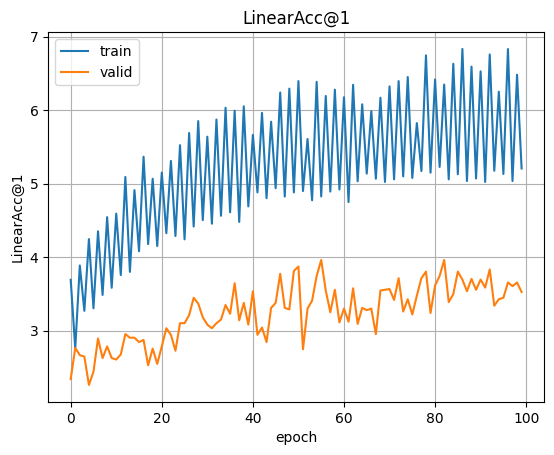

In [ ]:
plot_function( 'LinearAcc@1', history['train_linear_acc1_acc'],
                              history['valid_linear_acc1_acc']  )

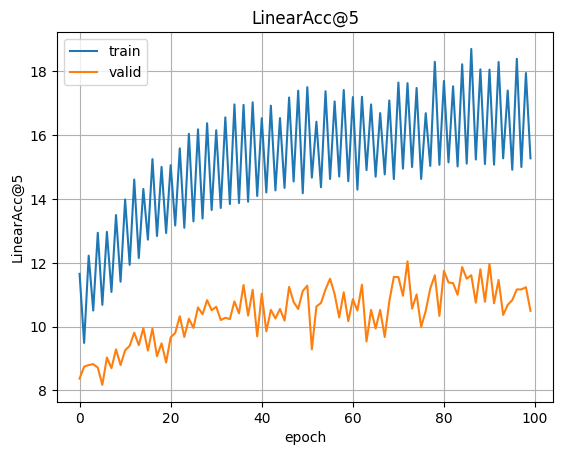

In [ ]:
plot_function( 'LinearAcc@5', history['train_linear_acc5_acc'],
                              history['valid_linear_acc5_acc']  )

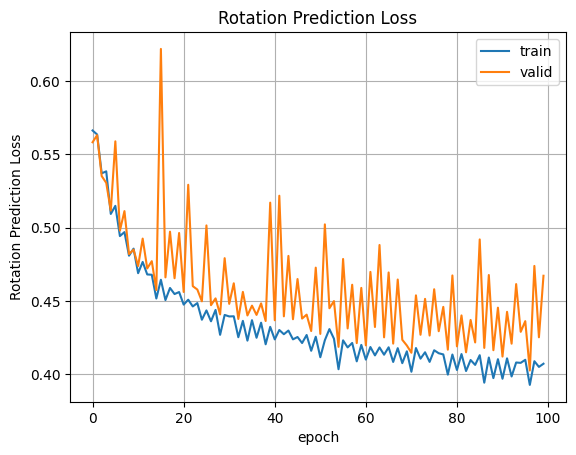

In [ ]:
plot_function( 'Rotation Prediction Loss', history['train_loss_rot_pred'],
                                           history['valid_loss_rot_pred'] )

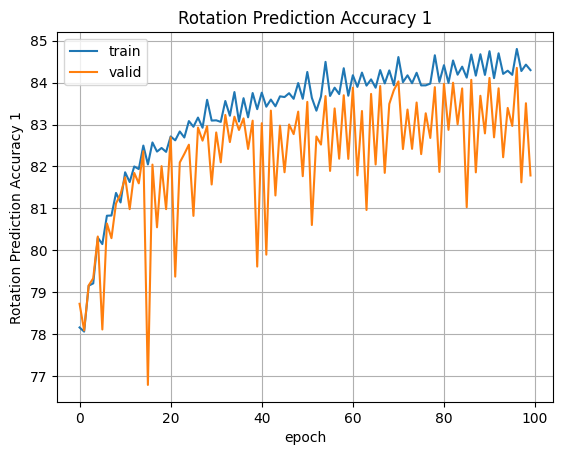

In [ ]:
plot_function( 'Rotation Prediction Accuracy 1', history['train_acc1_rot_pred'],
                                                 history['valid_acc1_rot_pred'] )

## 12. Evaluation Utilities

In [ ]:
import torch.utils.data as data
import matplotlib.pyplot as plt
from torchvision.utils import make_grid

In [ ]:
def load_model_and_data():

    ckpt_pth = osp.join( 'results', 'model_best.pth.tar' )
    ckpt     = torch.load( ckpt_pth, map_location = 'cpu' )

    model = RotationPrediction( num_classes )

    model.load_state_dict(ckpt['state_dict'])

    model.cuda()
    model.eval()

    linear_classifier = model.construct_classifier()
    linear_classifier.load_state_dict( ckpt['state_dict_linear'] )

    linear_classifier.cuda()
    linear_classifier.eval()

    return model, linear_classifier

In [ ]:
def evaluate_classifier( model, linear_classifier, loader ):

    correct1, correct5 = 0, 0
    with torch.no_grad():
        for images, target in tqdm(loader):

            images = images_to_cuda(images)
            target = target.cuda( non_blocking = True )

            out, zs = model(images)

            logits = linear_classifier(zs)
            acc1, acc5 = accuracy( logits, target, topk = (1, 5) )

            correct1 += acc1.item() * logits.shape[0]
            correct5 += acc5.item() * logits.shape[0]

    total = len(loader.dataset)

    return correct1 / total, correct5 / total

In [ ]:
def evaluate_accuracy( model, linear_classifier, train_loader, test_loader ):

    train_acc1, train_acc5 = evaluate_classifier( model, linear_classifier, train_loader )
    test_acc1,   test_acc5 = evaluate_classifier( model, linear_classifier, test_loader )

    print('Train Set')
    print(f'Top 1 Accuracy: {train_acc1}, Top 5 Accuracy: {train_acc5}\n')
    print('Test Set')
    print(f'Top 1 Accuracy: {test_acc1}, Top 5 Accuracy: {test_acc5}\n')

In [ ]:
def images_to_cuda(images):
    if isinstance(images, (tuple, list)):
        images = [x.cuda(non_blocking=True) for x in images]
    else:
        images = images.cuda(non_blocking=True)
        return images

## Linear Classification

In [ ]:
# Load the model, a separate linear classifier, training data loader, and testing data loader
model, linear_classifier = load_model_and_data()

In [ ]:
# Evaluate the model's accuracy on the testing data
evaluate_accuracy( model, linear_classifier, train_loader, test_loader )

  0%|          | 0/2868 [00:00<?, ?it/s]

  0%|          | 0/597 [00:00<?, ?it/s]

Train Set
Top 1 Accuracy: 7.900653594771242, Top 5 Accuracy: 20.39738562091503

Test Set
Top 1 Accuracy: 3.3570531603181246, Top 5 Accuracy: 10.682293846797823

